# Collision Avoidance Challenge - EDA

This notebook is used to perform exploratory data analysis (EDA) on the Collision Avoidance Challenge dataset.

# Setup

## Imports

In [1]:
import re
import os
import shutil
import sys
import numpy as np
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from sklearn.preprocessing import StandardScaler

## Set up the environment

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

## Add the src directory to the path

In [3]:
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Add paths

In [4]:
file_name = 'train_data.zip'
zip_path = '../dataset/'
extract_to = '../dataset/'
fig_path = '../figures/'
tab_path = '../tables/'

configs_path = "../configs"
configs_file_path = os.path.join(configs_path, "configs.yml")
filtered_path = os.path.join(configs_path, "filtered_columns.yml")
columns_path = os.path.join(configs_path, "columns.yml")

os.makedirs(extract_to, exist_ok=True)

if os.path.exists(fig_path):
    shutil.rmtree(fig_path)
os.makedirs(fig_path)

if os.path.exists(tab_path):
    shutil.rmtree(tab_path)
os.makedirs(tab_path)

## Extract the zip file

In [5]:
with zipfile.ZipFile(zip_path + file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Add Data Utils

In [6]:
def read_data(extract_to, file_name):
    csv_file = os.path.join(extract_to, file_name)
    df = pd.read_csv(csv_file)
    return df

## Add config utils

In [7]:
def load_configs():
    with open(configs_file_path, "r") as f:
        configs = yaml.safe_load(f)
    return configs

In [8]:
def load_columns_config():
    with open(filtered_path, "r") as f:
        configs = yaml.safe_load(f)
    return configs

In [9]:
def update_config(configs, col_path, value):
    current_node = configs
    for key in col_path[:-1]:
        current_node = current_node.get(key, {})
    current_node[col_path[-1]] = {**current_node[col_path[-1]], **value}
    return configs

In [10]:
def find_col_path(config, target_col_name, current_path=None):
    if current_path is None:
        current_path = []
    for key, value in config.items():
        new_path = current_path + [key]
        key_name = get_column_name(key)
        if key_name == get_column_name(target_col_name):
            return new_path
        if isinstance(value, dict):
            if not value.get('description', False): 
                result = find_col_path(value, target_col_name, new_path)
                if result is not None:
                    return result
    return None

In [11]:
def get_config(configs, col_name):
    col_path = find_col_path(configs, col_name)
    current_node = configs
    for key in col_path[:-1]:
        current_node = current_node.get(key, {})
    return current_node[col_path[-1]]

In [12]:
def update_yaml(columns_config):
    with open(filtered_path, 'w') as f:
        yaml.dump(columns_config, f)

In [13]:
def get_column_name(col_name):
    if len(col_name) > 2 and col_name.startswith(('t_', 'c_')):
        return 'x' + col_name[1:]
    return col_name

In [14]:
def drop_columns(df, should_keep, cols_to_drop, cols_remove_data):
    cols_to_drop = cols_to_drop - should_keep
    cols_remove_data = [col_data for col_data in cols_remove_data if col_data['removed'] in cols_to_drop]
    df = df.drop(columns=cols_to_drop)
    return [df, cols_to_drop, cols_remove_data]

In [15]:
def get_should_keep_columns(columns_config, removed_data):
    should_keep = set()
    for col_data in removed_data:
        removed_col_name = get_column_name(col_data['removed'])
        col_path = find_col_path(columns_config, removed_col_name)
        if col_path:
            current_node = columns_config 
            for key in col_path:
                current_node = current_node.get(key, {})
            is_kept = current_node.get('kept', False)
            if is_kept:
                should_keep.add(col_path[-1])
    return should_keep

In [16]:
def to_booktabs(df, file_path, **kwargs):
    latex = df.to_latex(**kwargs)
    
    start = latex.find('\\begin{tabular}')
    end = latex.find('\\end{tabular}') + len('\\end{tabular}')
    tabular_content = latex[start:end]
    
    tabular_clean = tabular_content.replace('\\hline', '\\toprule', 1)\
                                   .replace('\\hline', '\\bottomrule')\
                                   .replace('\\hline', '\\midrule')\
                                   .replace('%', '\\%')\
                                   .replace('_', '\\_')
    
    caption = kwargs.pop('caption', '')
    label = f"tab:{caption.replace(' ', '-').lower()}"
    
    figure_complete = f"""\\begin{{table}}[htpb]
\\centering
\\resizebox{{\\columnwidth}}{{!}}{{{tabular_clean}}}
\\caption{{{caption}}}
\\label{{{label}}}
\\end{{table}}
"""
    
    with open(file_path, 'w') as f:
        f.write(figure_complete)

In [17]:
def to_figure(path, caption):
    caption = caption.replace('_', '-')
    label = f"fig:{caption.replace(' ', '-').lower()}"
    
    figure_content = f"""\\begin{{figure}}[htpb]
    \\centering
    \\resizebox{{\\columnwidth}}{{!}}{{\\includegraphics{{{path}}}}}
    \\caption{{{caption}}}
    \\label{{{label}}}
\\end{{figure}}"""

    tex_path = path.replace('png', 'tex')
    with open(tex_path, 'w') as f:
        f.write(figure_content)

## Copy the columns file to the working columns (filtered_columns.yml) file

In [18]:
if os.path.exists(filtered_path):
    os.remove(filtered_path)

shutil.copy2(columns_path, filtered_path)

'../configs/filtered_columns.yml'

## Get the Configs

In [19]:
eda_configs = load_configs()

In [20]:
columns_config = load_columns_config()

# Read the data

In [21]:
df = read_data(extract_to, file_name)

# Preliminary Information

## First Lines

Display the first lines of the dataset.

In [22]:
file_path = os.path.join(tab_path, 'preliminaries', 'first_lines.tex')
os.makedirs(os.path.dirname(file_path), exist_ok=True)

to_booktabs(
    df.head().T.reset_index().rename(columns={'index': 'original_column'}),
    file_path,
    index=False,
    caption="First Lines",
    column_format='l' + 'c' * (len(df.columns) - 1),
)

## Dataset Dimensions

Display the dataset number of rows and columns before any treatment.

In [23]:
summary_df = pd.DataFrame({
    'Number of rows': [len(df)],
    'Number of columns': [len(df.columns)]
})

file_path = os.path.join(tab_path, 'preliminaries', 'dimensions.tex')
os.makedirs(os.path.dirname(file_path), exist_ok=True)

to_booktabs(
    summary_df,
    file_path,
    index=False,
    caption="Dataset Dimensions",
    column_format='cc',
)

# Preliminary Filtering

Filter columns marked as not kept in the columns file.

In [24]:
def get_columns_to_remove(config):
    columns_to_remove = []
    for key, value in config.items():
        if isinstance(value, dict):
            if 'kept' in value:
                if value['kept'] == False:
                    if (key.startswith('x_')):
                        columns_to_remove.append('c' + key[1:])
                        columns_to_remove.append('t' + key[1:])
                    else:
                        columns_to_remove.append(key)
            else:
                columns_to_remove.extend(get_columns_to_remove(value))
    return [col for col in columns_to_remove if col in df.columns]

## Drop columns marked as not kept in the columns file.

In [25]:
columns_to_remove = get_columns_to_remove(columns_config['columns'])
df = df.drop(columns=columns_to_remove)

## Number of columns after removing the filtered columns.

In [26]:
summary_df = pd.DataFrame({
    'Number of columns': [len(df.columns)]
})

file_path = os.path.join(tab_path, 'preliminaries', 'columns_after_filter.tex')
os.makedirs(os.path.dirname(file_path), exist_ok=True)

to_booktabs(
    summary_df,
    file_path,
    index=False,
    caption="Number of Columns After Filtering",
    column_format='c',
)

display(summary_df)

Number of columns
0                 42

# Columns Basic Statistics

Display the basic statistics of the columns.

In [27]:
def display_columns_stats(df, caption, file_path):
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format):
        stats = df.describe().T.sort_index(ascending=True)[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        display(stats)
        to_booktabs(
            stats,
            os.path.join(file_path, "columns_stats.tex"),
            index=True,
            caption=caption,
            label=f"tab:{caption.replace(' ', '-').lower()}",
            position='htpb',
            column_format='l' + 'c' * (len(stats.columns))
        )

In [28]:
file_path = os.path.join(tab_path, 'columns_stats')
os.makedirs(file_path, exist_ok=True)
display_columns_stats(df, "Columns Basic Statistics", file_path)

mean        std         min         25%        50%  \
AP                        8.608      8.454       0.000       4.000      6.000   
F10                      78.096     14.702      66.000      69.000     72.000   
F3M                      79.049     14.078      69.000      71.000     74.000   
SSN                      20.589     25.365       0.000       0.000     13.000   
azimuth                  -0.001     46.643    -112.882     -35.779     -0.813   
c_actual_od_span         12.027      7.913       0.000       6.430     11.250   
c_cd_area_over_mass       0.784      2.342    -128.179       0.177      0.439   
c_cr_area_over_mass       0.346      0.965      -0.712       0.052      0.181   
c_h_apo               1,020.431  2,584.384     302.794     641.998    726.165   
c_h_per                 623.315    113.238     113.247     550.757    640.625   
c_j2k_ecc                 0.016      0.067       0.000       0.002      0.004   
c_j2k_inc                86.473     15.492       1.878      74.070     87.435   
c_j2k_sma             7,200.010  1,287.124   6,643.205   6,991.471  7,070.527   
c_obs_available          65.933    102.420       3.000      21.000     30.000   
c_sedr                    0.003      0.015      -0.107       0.000      0.001   
c_weighted_rms            1.979      1.136       0.356       1.503      1.891   
elevation                -0.020      2.163     -66.394      -0.142      0.004   
event_id              6,566.872  3,798.407       0.000   3,306.000  6,558.000   
geocentric_latitude      -0.664     67.840     -87.970     -73.000     -1.983   
mahalanobis_distance    192.603    433.681       0.000      22.406     71.170   
miss_distance        16,531.662 14,269.028       9.000   4,683.000 12,439.000   
relative_position_n      95.253 16,063.415 -50,995.500  -6,974.325     38.950   
relative_position_r     -40.198    644.193  -4,815.000    -301.475    -27.300   
relative_position_t      53.578 14,780.304 -62,184.200  -5,773.950      0.600   
relative_speed       10,655.820  4,340.236       4.000   7,421.000 12,262.000   
relative_velocity_n     -54.009  5,301.272 -10,056.600  -5,209.800   -128.000   
relative_velocity_r       0.028    145.105  -2,295.300     -24.300     -0.800   
relative_velocity_t  -8,761.327  5,244.684 -16,924.000 -13,946.000 -9,915.500   
risk                    -19.341     10.012     -30.000     -30.000    -17.871   
t_actual_od_span          3.800      1.312       0.010       3.460      3.710   
t_cd_area_over_mass       0.013      0.008      -0.099       0.008      0.013   
t_cr_area_over_mass       0.011      0.011       0.000       0.005      0.009   
t_h_apo                 674.665    107.437     299.131     629.658    703.978   
t_h_per                 647.903    110.138     273.073     597.520    680.184   
t_j2k_ecc                 0.002      0.002       0.000       0.001      0.002   
t_j2k_inc                95.409      4.207      87.237      92.024     97.893   
t_j2k_sma             7,039.421    108.235   6,675.032   6,995.626  7,064.011   
t_obs_available         952.684  1,023.700      29.000     430.000    483.000   
t_rcs_estimate            2.960      2.372       0.011       0.447      2.646   
t_sedr                    0.000      0.001      -0.000       0.000      0.000   
t_weighted_rms            1.123      0.164       0.525       0.998      1.107   
time_to_tca               3.350      2.013      -0.150       1.588      3.298   

                            75%        max  
AP                       10.000    108.000  
F10                      80.000    246.000  
F3M                      82.000    159.000  
SSN                      30.000    172.000  
azimuth                  35.989    130.159  
c_actual_od_span         16.270    154.040  
c_cd_area_over_mass       0.693    147.913  
c_cr_area_over_mass       0.305     59.155  
c_h_apo                 812.733 70,032.460  
c_h_per                 702.281    834.638  
c_j2k_ecc                 0.009      0.834  
c_j

# Column Preprocessing

## Missing values and Infs Treatment

Display and treat missing values and Infs.
NaNs are substituted by column mean.
-inf and +inf are substituted by column min and max, respectively.

In [29]:
def get_missing_and_inf_values(df):
    num_df = df.select_dtypes(include=[np.number])
    result = pd.DataFrame(
            {
            'Missing Values (%)': num_df.isnull().sum() / len(df) * 100,
            'Infs (%)': np.isinf(num_df).sum() / len(df) * 100,
            '-Inf (%)': np.isneginf(num_df).sum() / len(df) * 100,
            }
    ).sort_values(['Missing Values (%)', 'Infs (%)', '-Inf (%)'], ascending=[False, False, False])
    result = result[(result['Missing Values (%)'] > 0) | (result['Infs (%)'] > 0) | (result['-Inf (%)'] > 0)]
    return result

In [30]:
def plot_missing_values(missing_values, path):
    missing_values = missing_values[missing_values['Missing Values (%)'] > 0]
    if len(missing_values) == 0:
        return
    fig, ax = plt.subplots(figsize=(10, 8))

    y_positions = range(len(missing_values))
    values = missing_values['Missing Values (%)']
    
    bars = ax.barh(
        y=y_positions,
        width=values,
        align='center'
    )

    ax.set_yticks(y_positions)
    ax.set_yticklabels(missing_values.index, fontsize=8)
    plt.setp(ax.get_yticklabels(), ha='right')

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_ylim(-0.5, len(missing_values) - 0.5)
    plt.ylabel("Coluna", fontsize=8)
    plt.xlabel("Valores ausentes (%)", fontsize=8)

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width + 0.5,                 
            bar.get_y() + bar.get_height() / 2,
            f'{values.iloc[i]:.3f}%',   
            va='center',
            ha='left',
            fontsize=6
        )
        
    ax.tick_params(axis='x', labelsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(path, "missing_values.png"))
    plt.show()
    plt.close(fig)

    to_figure(os.path.join(path, "missing_values.png"), "Missing Values")

In [31]:
def plot_missing_values_table(missing_values, caption, file_path):
    to_booktabs(
        missing_values,
        os.path.join(file_path, "missing_values.tex"),
        index=True,
        caption=caption,
        column_format='l' + 'c' * (len(missing_values.columns))
    )

### Missing Values and Infs before treatment

Display missing values and Infs. Only columns with at least 1 missing value or Inf are displayed.


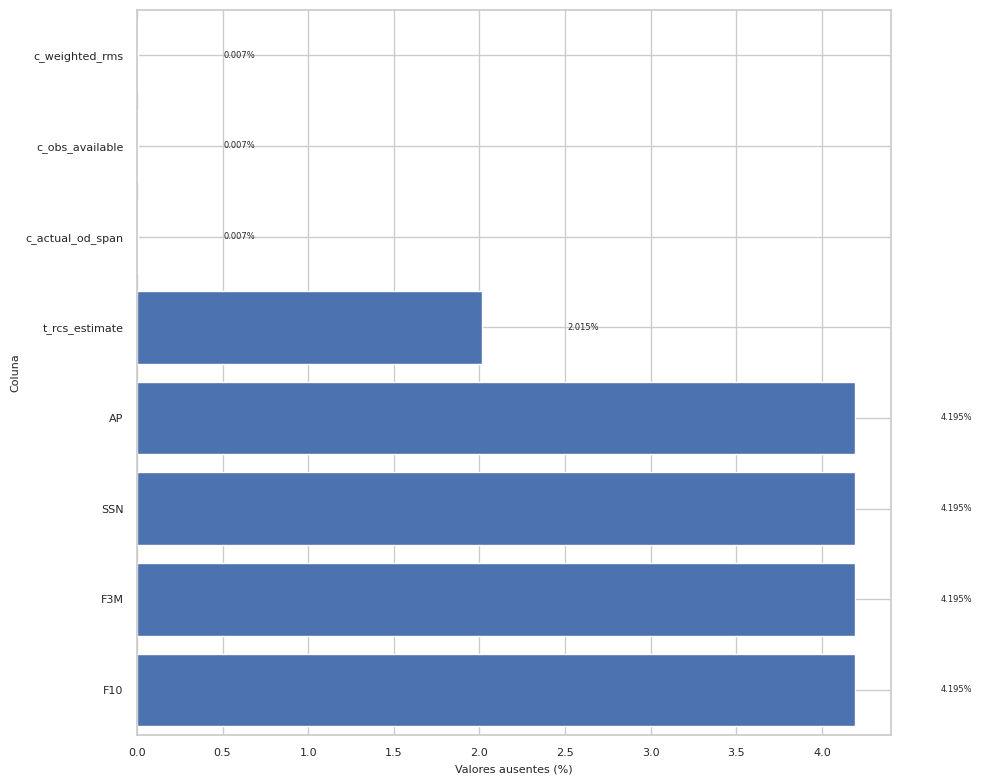

F10                0.00000
F3M                0.00000
SSN                0.00000
AP                 0.00000
t_rcs_estimate     0.00000
c_actual_od_span   0.00000
c_obs_available    0.00000
c_weighted_rms     0.00000
Name: Infs (%), dtype: float64

F10                0.00000
F3M                0.00000
SSN                0.00000
AP                 0.00000
t_rcs_estimate     0.00000
c_actual_od_span   0.00000
c_obs_available    0.00000
c_weighted_rms     0.00000
Name: -Inf (%), dtype: float64

In [32]:
path = os.path.join(fig_path, 'missing_values')
os.makedirs(path, exist_ok=True)

missing_values = get_missing_and_inf_values(df)
plot_missing_values(missing_values, path)

with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.5f}'.format):
    display(missing_values['Infs (%)'])
    display(missing_values['-Inf (%)'])

### Remove NaNs, -inf and +inf

Substitute NaNs by column mean.
Substitute -inf and +inf by column min and max, respectively.

In [33]:
for col in df.select_dtypes(include=np.number).columns:
    df[col] = np.nan_to_num(
        df[col],
        nan=df[col].mean(),
        posinf=df[col].max(),
        neginf=df[col].min()
    )

## Outliers Treatment
Perform Standard Scaler transformation and capping (for values above and below the upper and lower thresholds).

In [34]:
def get_outliers(df, iqr_factor):
    outlier_summary = {}
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (iqr_factor * IQR)
        upper_bound = Q3 + (iqr_factor * IQR)
        
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers_count = df[outliers_mask].shape[0]
            
        percent_outliers = (outliers_count / len(df)) * 100
        if percent_outliers >= 0:  
            outlier_summary[col] = {
                'Count': outliers_count,
                '%': percent_outliers,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound
            }
    return outlier_summary

In [35]:
def plot_outliers_table(outlier_summary, caption, file_path):
    if len(outlier_summary) == 0:
        return
    summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index')
    summary_df = summary_df.sort_values(by='%', ascending=False)

    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format):
        display(summary_df)
        to_booktabs(
            summary_df,
            os.path.join(file_path, "outliers.tex"),
            index=True,
            caption=caption,
            column_format='l' + 'c' * (len(summary_df.columns)),
        )

In [36]:
def plot_outliers_boxplot(outliers, col, outliers_summary, path):
    fig, ax = plt.subplots(figsize=(9, 2))

    ax.boxplot(outliers.values, vert=False)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Outliers')
    ax.axvline(outliers_summary['Lower Bound'], color='blue', linestyle='--')
    ax.axvline(outliers_summary['Upper Bound'], color='blue', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(os.path.join(path, "outliers_boxplot_{}.png".format(col)))
    plt.show()
    plt.close(fig)
    to_figure(os.path.join(path, "outliers_bosplot_{}.png".format(col)), f'Outliers Boxplot for {col}')

In [37]:
def plot_outliers_kde(outliers, col, outliers_summary, path):
    fig, ax = plt.subplots(figsize=(9, 2))
    
    sns.kdeplot(outliers, fill=True, color='red', alpha=0.6, ax=ax)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidade')
    ax.axvline(outliers_summary['Lower Bound'], color='blue', linestyle='--')
    ax.axvline(outliers_summary['Upper Bound'], color='blue', linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(path, "outliers_kde_{}.png".format(col)))
    plt.show()
    plt.close(fig)
    to_figure(os.path.join(path, "outliers_kde_{}.png".format(col)), f'Outliers KDE for {col}')

In [38]:
def plot_outliers(outliers, col, outliers_summary, path):
    plot_outliers_kde(outliers, col, outliers_summary, path)
    plot_outliers_boxplot(outliers, col, outliers_summary, path)

### Outliers Distribution and BoxPlot Before Transformation

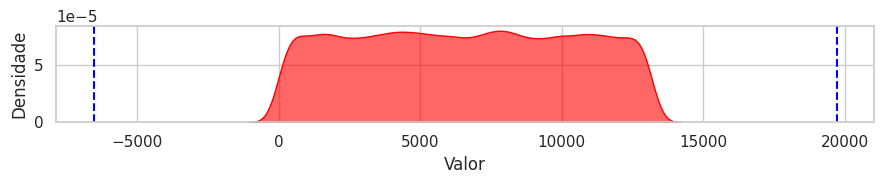

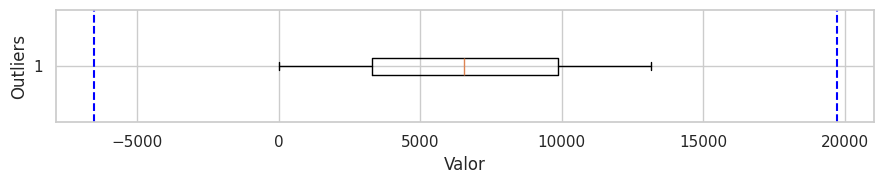

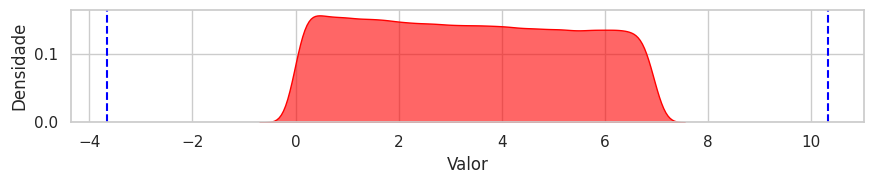

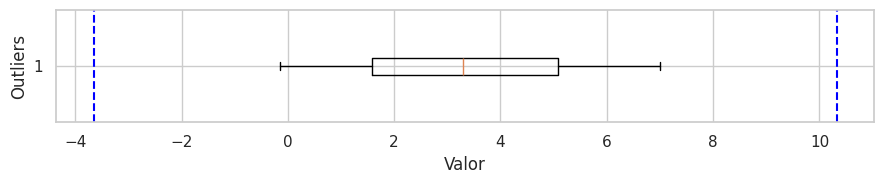

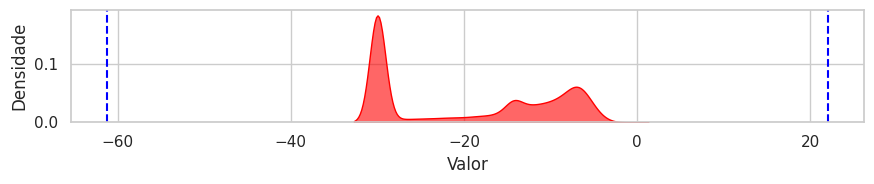

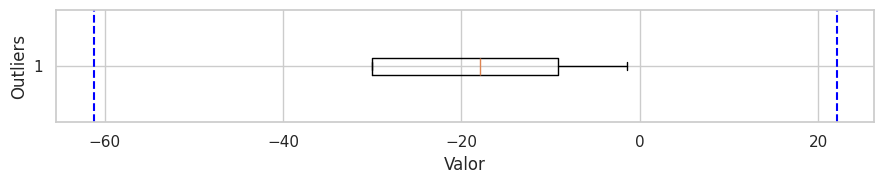

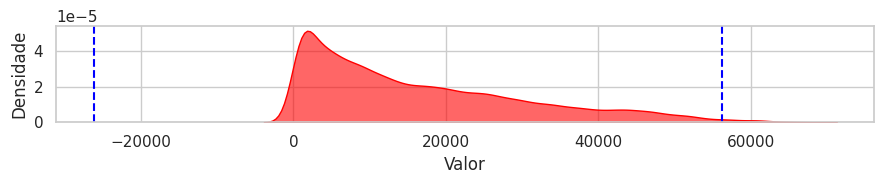

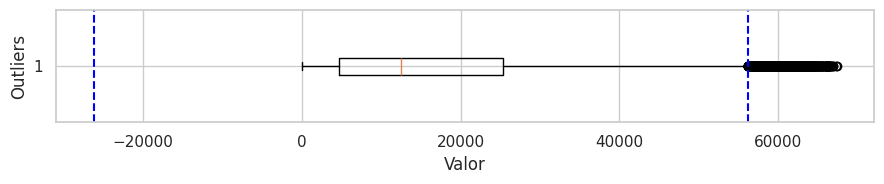

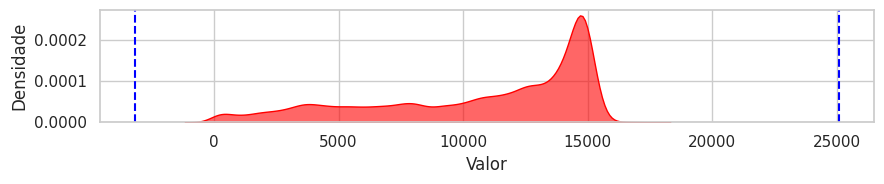

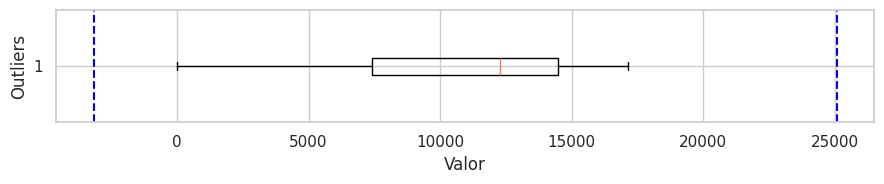

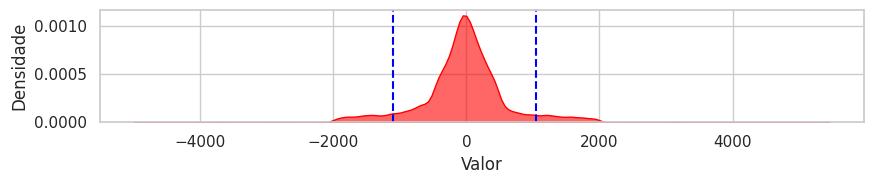

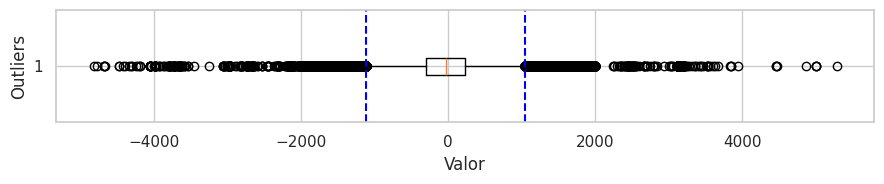

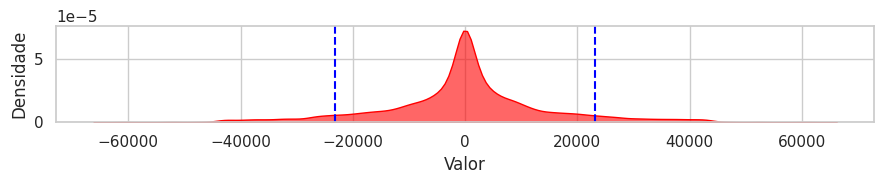

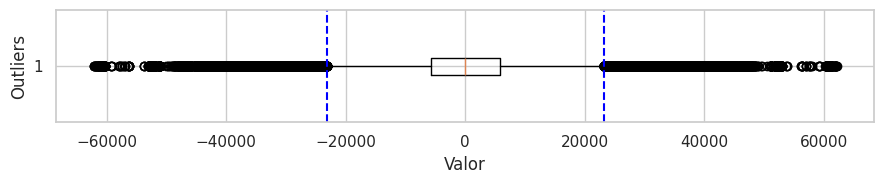

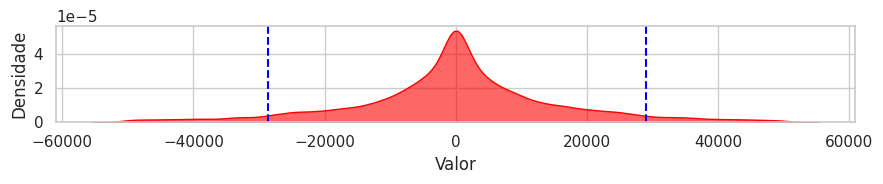

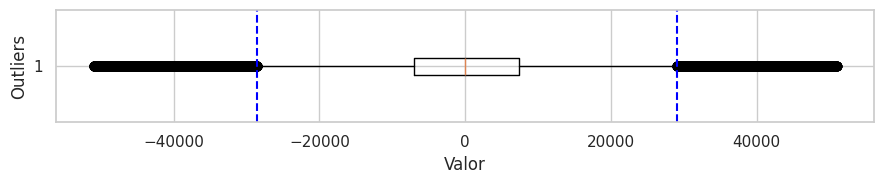

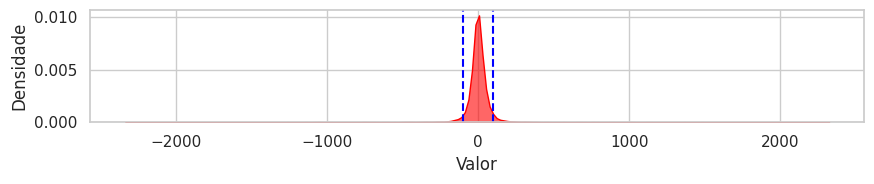

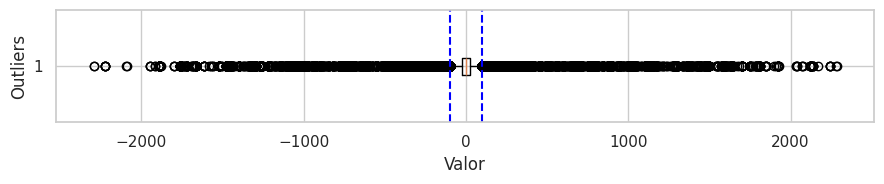

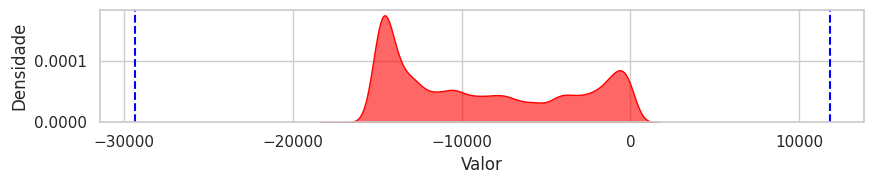

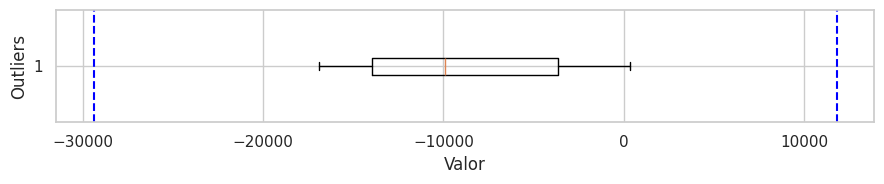

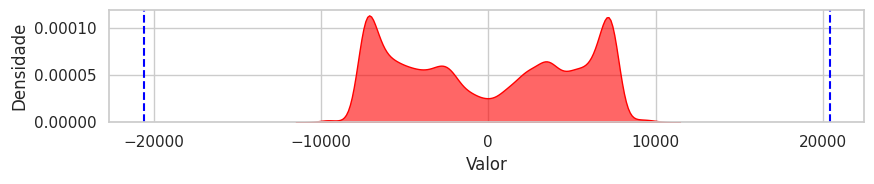

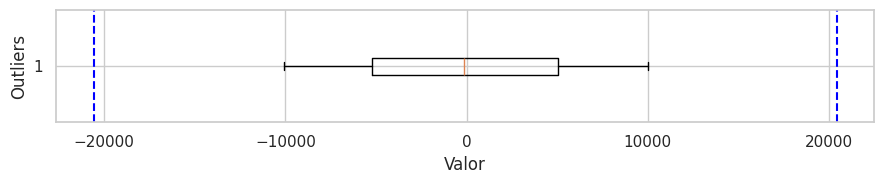

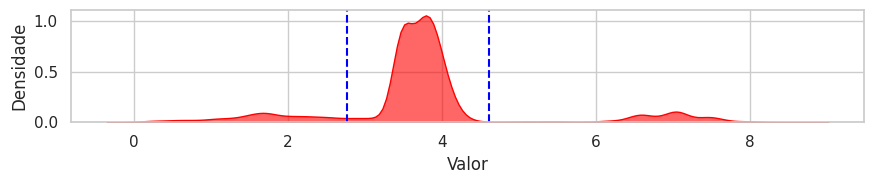

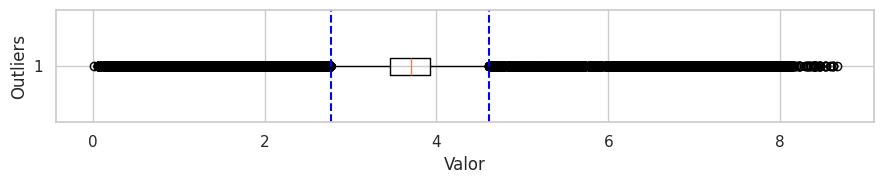

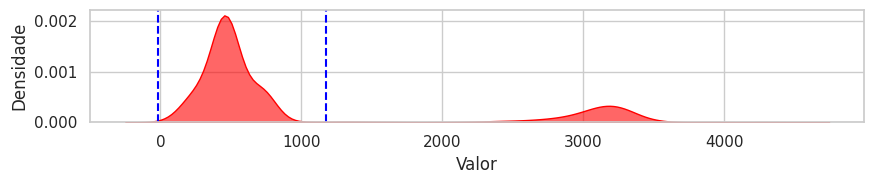

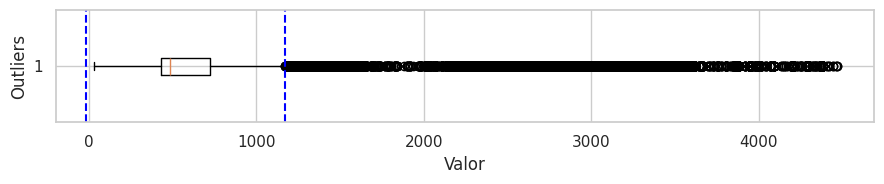

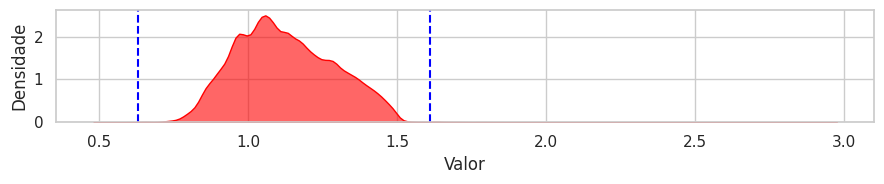

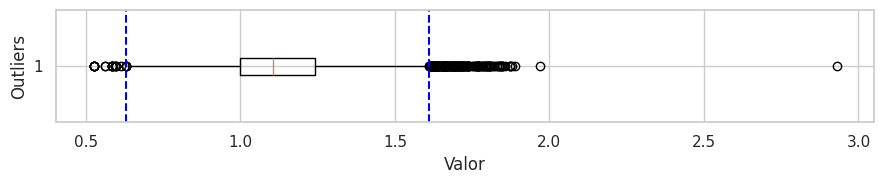

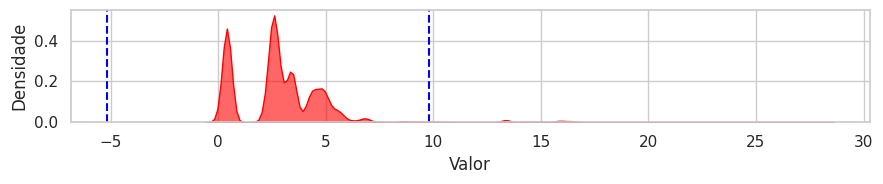

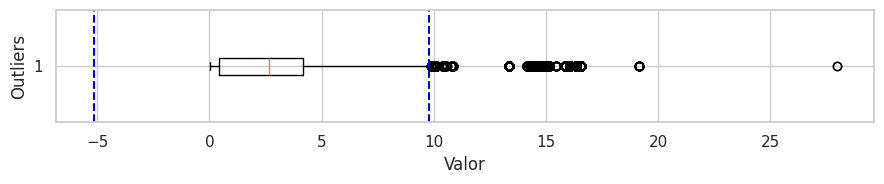

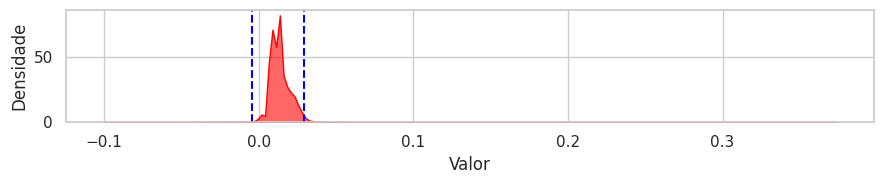

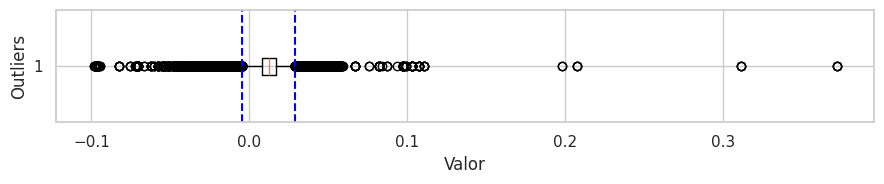

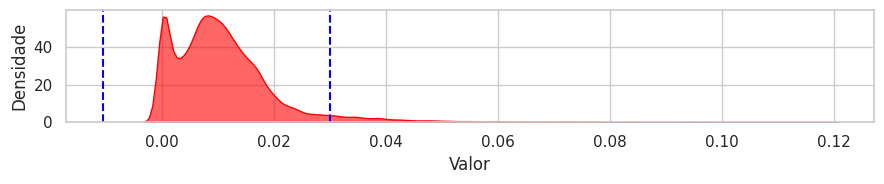

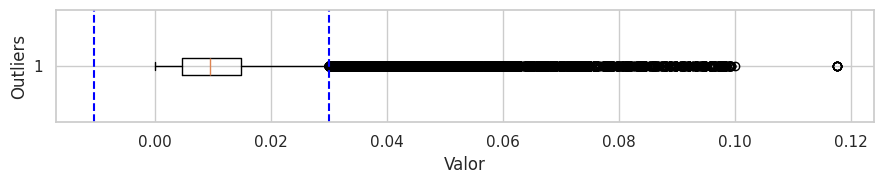

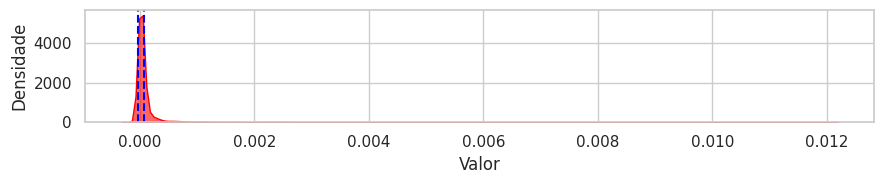

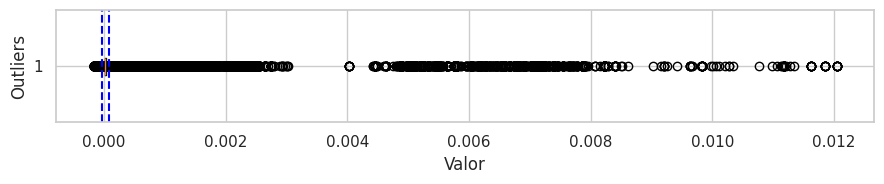

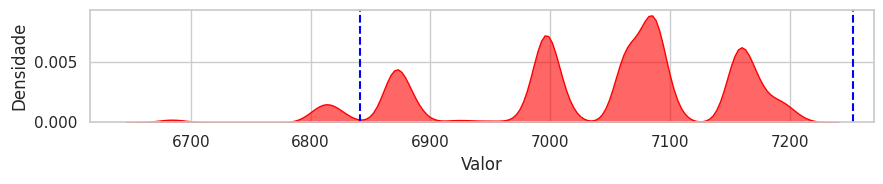

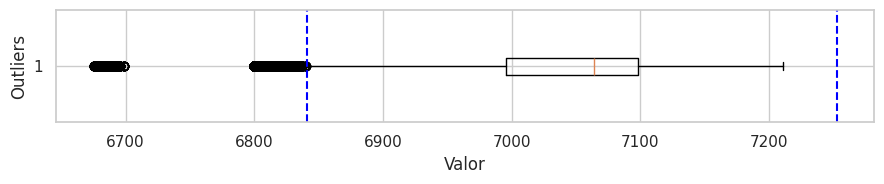

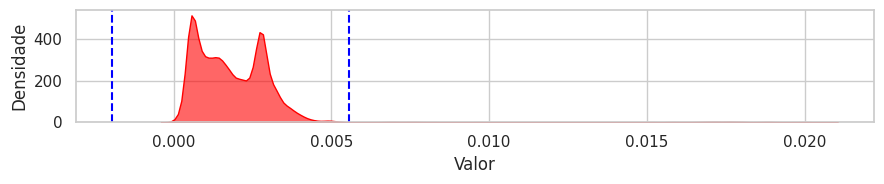

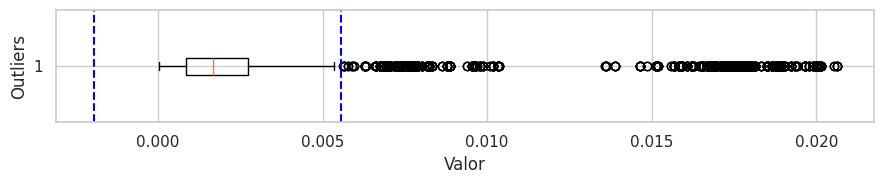

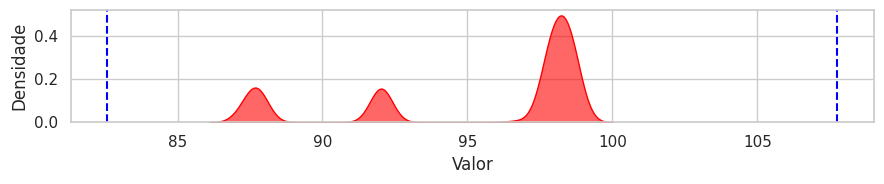

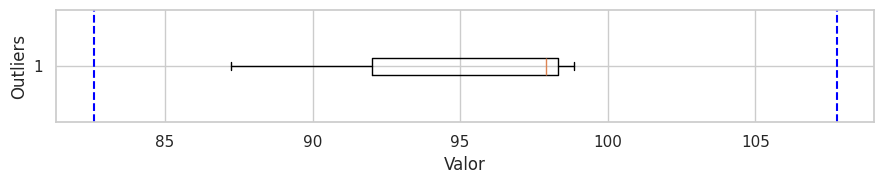

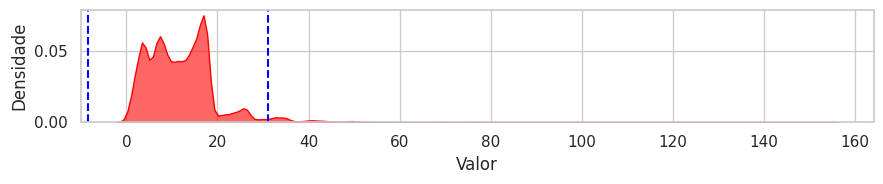

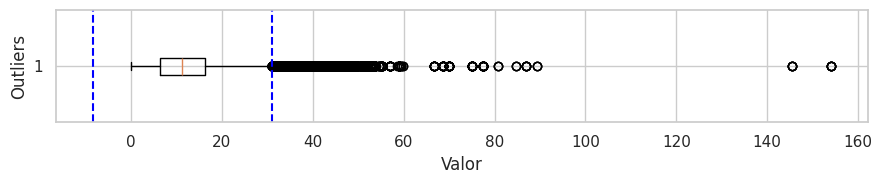

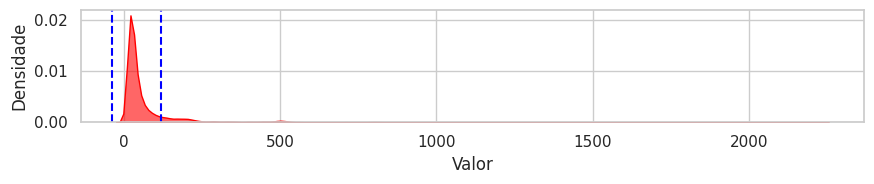

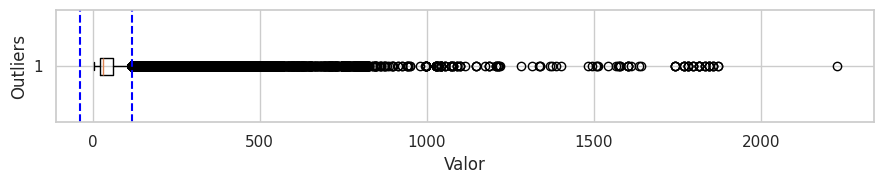

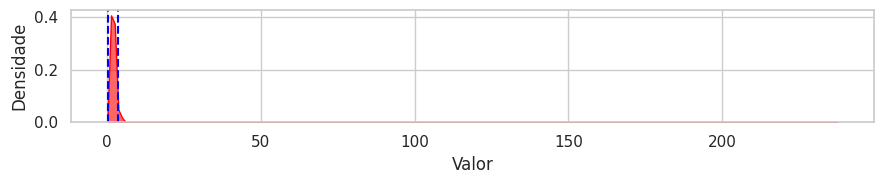

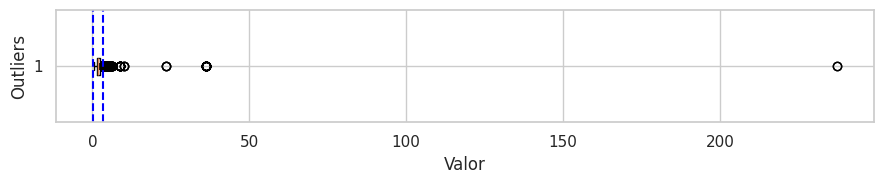

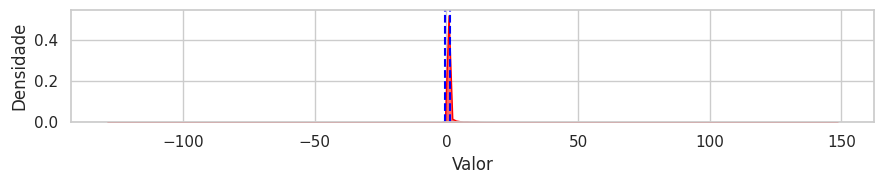

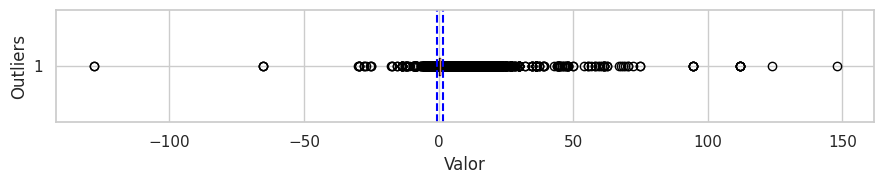

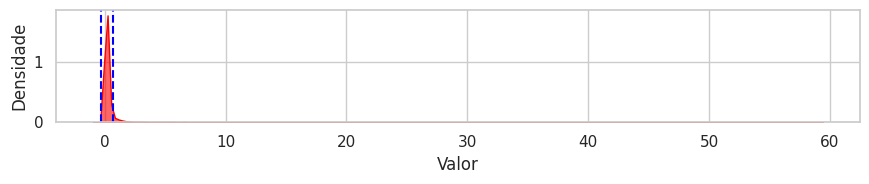

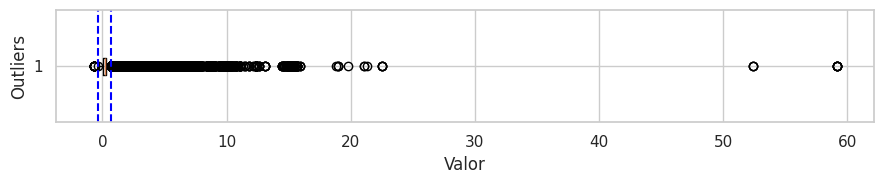

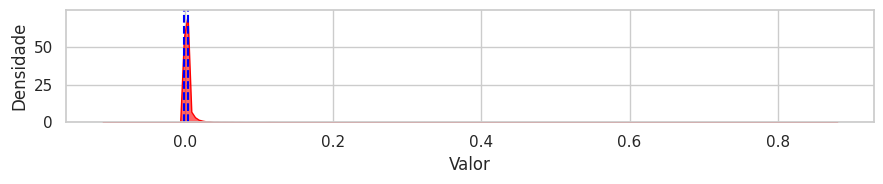

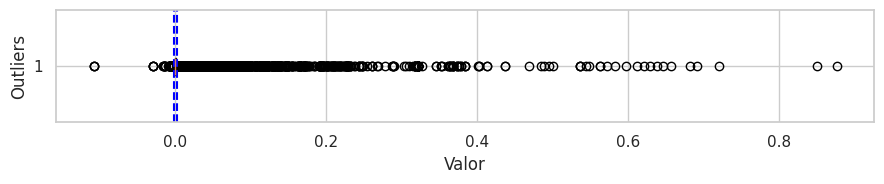

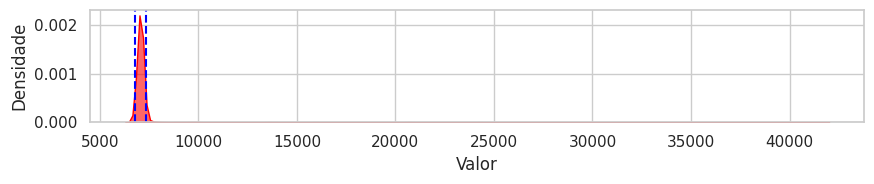

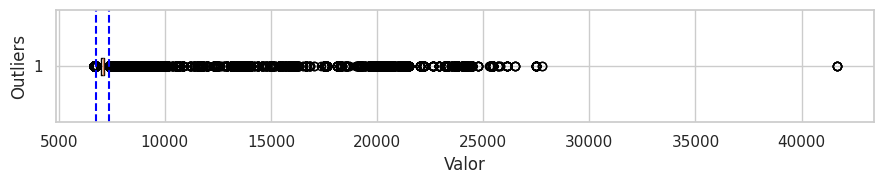

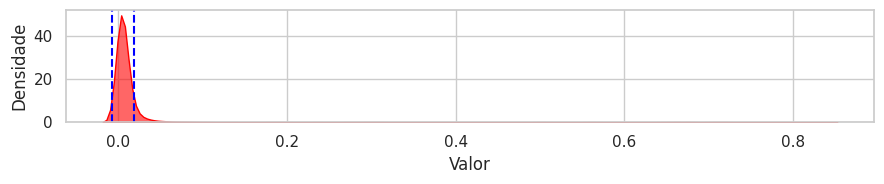

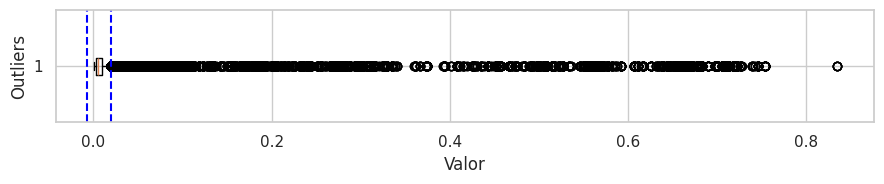

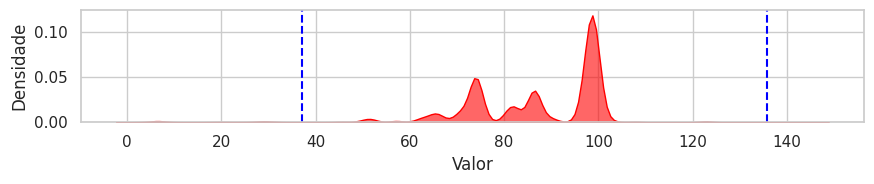

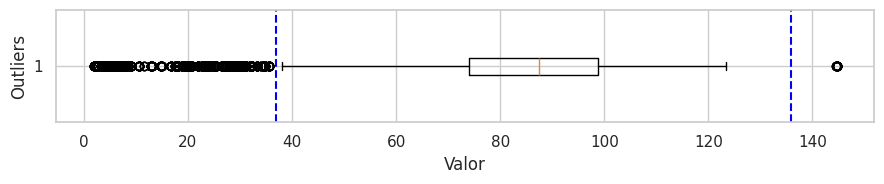

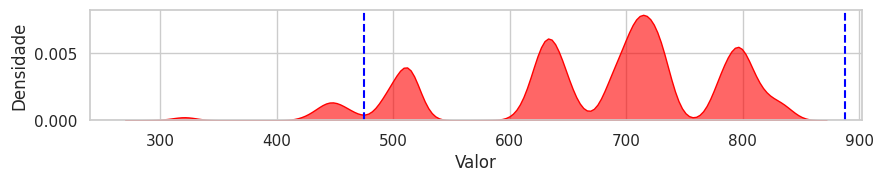

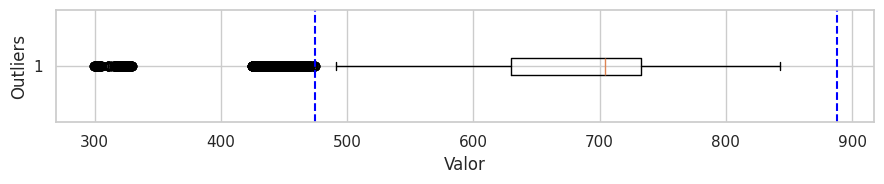

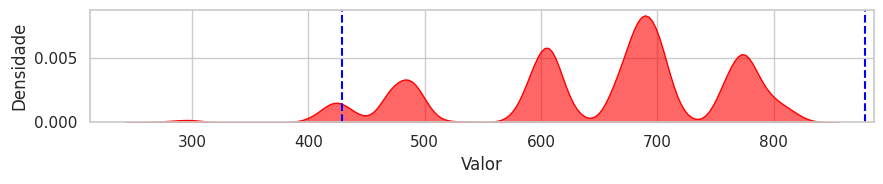

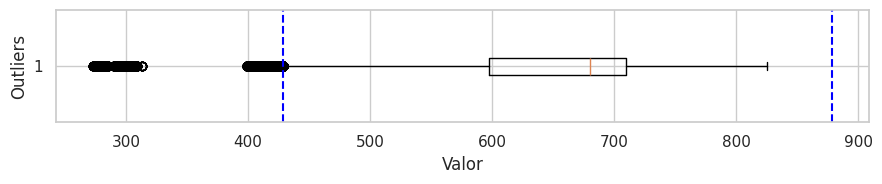

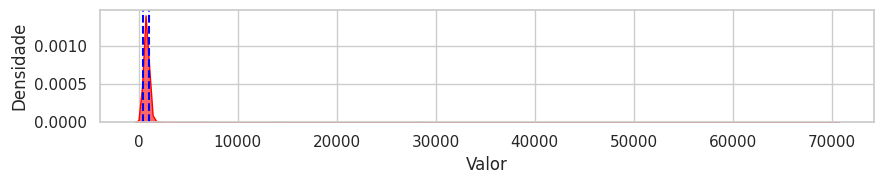

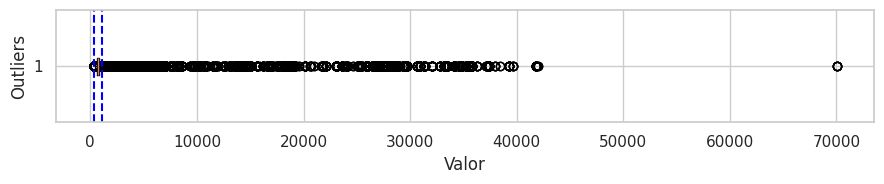

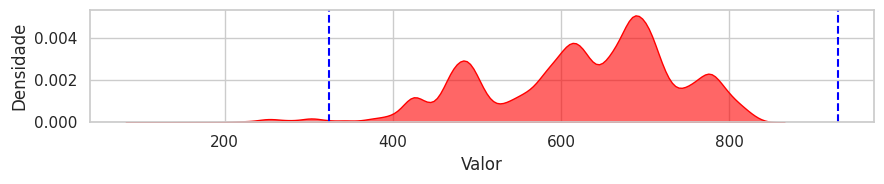

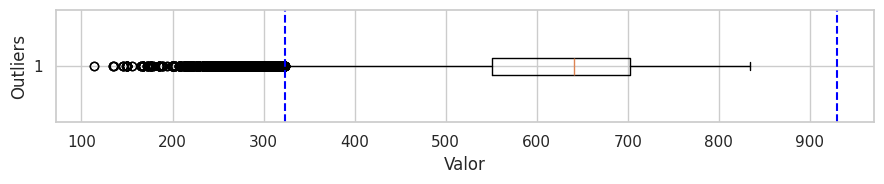

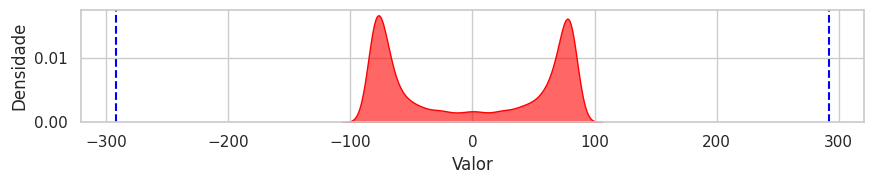

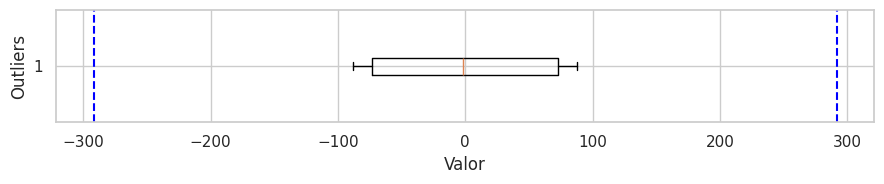

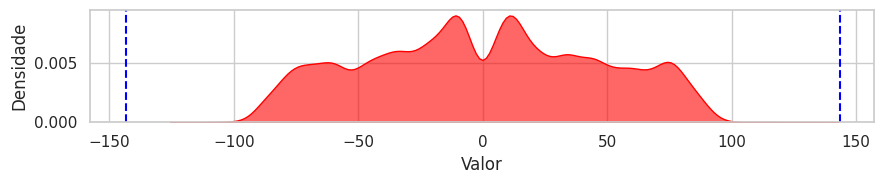

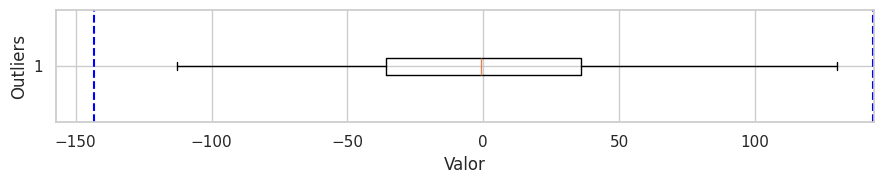

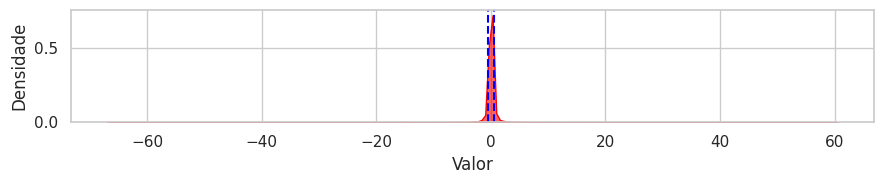

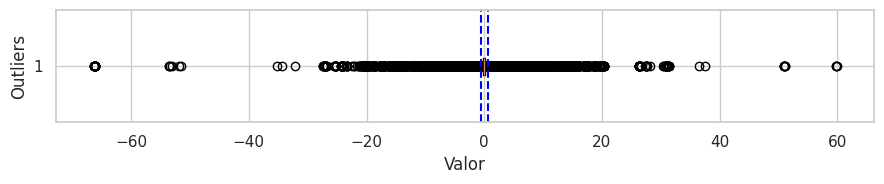

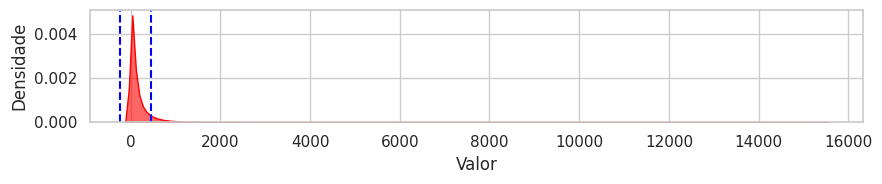

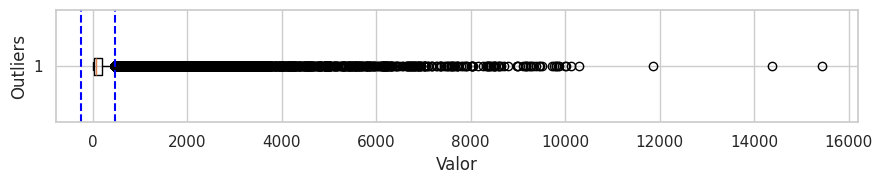

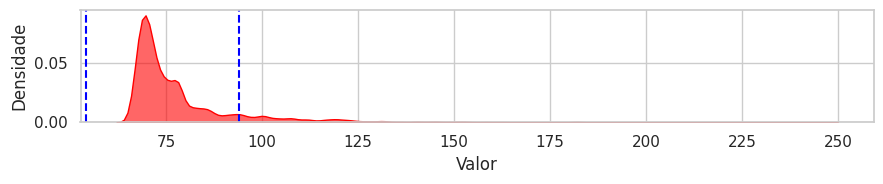

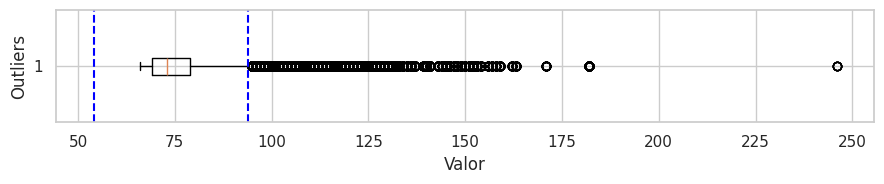

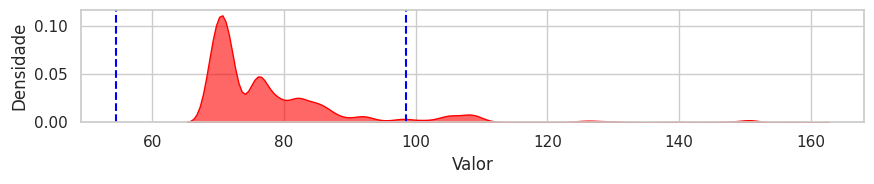

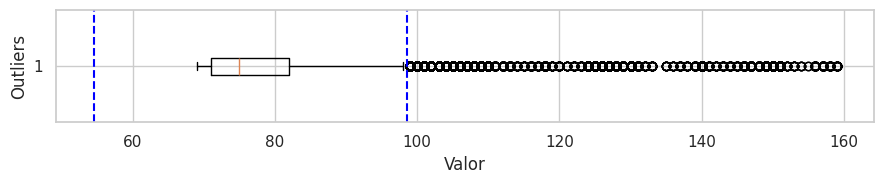

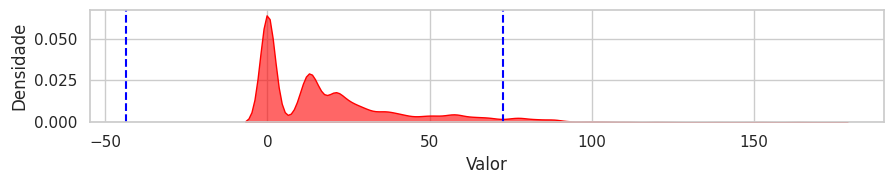

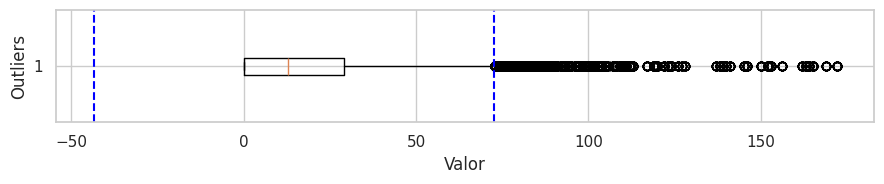

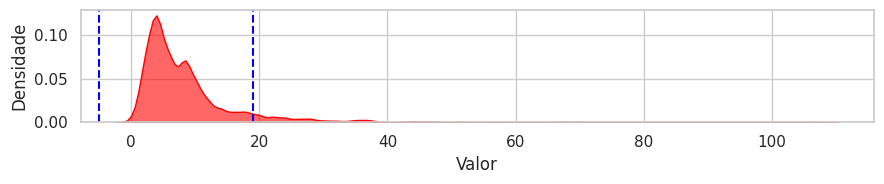

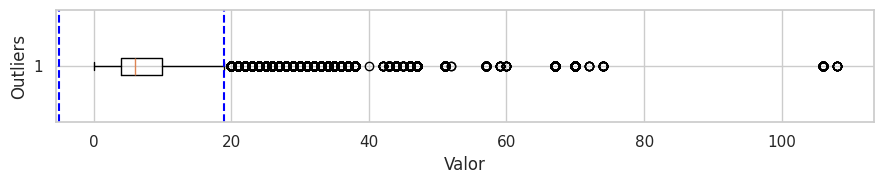

In [39]:
iqr_factor = get_config(eda_configs, 'iqr_factor')
outlier_summary = get_outliers(df, iqr_factor)

path = os.path.join(fig_path, 'outliers', 'before')
os.makedirs(path, exist_ok=True)

for col in outlier_summary.keys():
    plot_outliers(df[col], col, outlier_summary[col], path)

### Outliers Count and Percentage Table Before Transformation

In [40]:
iqr_factor = get_config(eda_configs, 'iqr_factor')
outlier_summary = get_outliers(df, iqr_factor)

path = os.path.join(tab_path, 'outliers', 'before')
os.makedirs(path, exist_ok=True)
plot_outliers_table(outlier_summary, "Initial Outliers Summary", path)

Count      %  Lower Bound  Upper Bound
t_actual_od_span      38046 23.394        2.770        4.610
t_obs_available       30270 18.612      -15.500    1,172.500
t_sedr                29325 18.031       -0.000        0.000
elevation             25250 15.526       -0.563        0.561
relative_position_t   21593 13.277  -23,175.675   23,228.925
c_obs_available       21284 13.087      -37.500      118.500
c_sedr                20506 12.609       -0.001        0.003
relative_position_r   18928 11.638   -1,108.888    1,044.213
F10                   18156 11.164       54.000       94.000
mahalanobis_distance  15832  9.735     -241.701      462.583
relative_position_n   15325  9.423  -28,587.825   29,048.175
c_j2k_ecc             15105  9.288       -0.008        0.019
relative_velocity_r   14819  9.112      -97.350       97.450
F3M                   14635  8.999       54.500       98.500
c_cr_area_over_mass   13052  8.025       -0.328        0.685
AP                    12958  7.968       -5.000       19.000
c_cd_area_over_mass   11841  7.281       -0.596        1.466
c_h_apo                9566  5.882      385.895    1,068.836
t_h_apo                8812  5.418      474.716      887.894
t_j2k_sma              8808  5.416    6,841.271    7,252.884
SSN                    8641  5.313      -43.500       72.500
t_cr_area_over_mass    8533  5.247       -0.011        0.030
t_h_per                6990  4.298      428.982      878.417
c_j2k_sma              6310  3.880    6,765.823    7,367.552
c_weighted_rms         6165  3.791        0.307        3.495
t_cd_area_over_mass    4804  2.954       -0.004        0.029
c_actual_od_span       4788  2.944       -8.330       31.030
t_rcs_estimate         3113  1.914       -5.163        9.797
c_j2k_inc              2418  1.487       37.003      135.849
c_h_per                2320  1.427      323.472      929.567
miss_distance          1473  0.906  -26,214.000   56,178.000
t_j2k_ecc              1325  0.815       -0.002        0.006
t_weighted_rms          252  0.155        0.630        1.611
event_id                  0  0.000   -6,535.500   19,708.500
relative_velocity_t       0  0.000  -29,396.750   11,805.250
relative_speed            0  0.000   -3,179.500   25,088.500
risk                      0  0.000      -61.240       22.067
time_to_tca               0  0.000       -3.655       10.327
t_j2k_inc                 0  0.000       82.581      107.762
relative_velocity_n       0  0.000  -20,593.050   20,428.950
geocentric_latitude       0  0.000     -291.907      291.844
azimuth                   0  0.000     -143.432      143.642

### Standard Scaler Transformation

In [41]:
#iqr_factor = get_config(eda_configs, "iqr_factor")
#outlier_summary = get_outliers(df, iqr_factor)

#cols_with_outliers = list(outlier_summary.keys())
#scaler = StandardScaler()
#df[cols_with_outliers] = scaler.fit_transform(df[cols_with_outliers])

### Intermediate Outliers Distribution and BoxPlot

In [42]:
#iqr_factor = get_config(eda_configs, 'iqr_factor')
#outlier_summary = get_outliers(df, iqr_factor)

#path = os.path.join(fig_path, 'outliers', 'intermediate')
#os.makedirs(path, exist_ok=True)

#for col in outlier_summary.keys():
#    plot_outliers(df[col], col, outlier_summary[col], path)

### Capping

Remove outliers from the dataset that are above the lower bound cap and below or equal to the upper bound cap.

In [43]:
lower_bound_outliers_capping = get_config(eda_configs, 'lower_bound_outliers_capping')
upper_bound_outliers_capping = get_config(eda_configs, 'upper_bound_outliers_capping')

iqr_factor = get_config(eda_configs, 'iqr_factor')
outlier_summary = get_outliers(df, iqr_factor)
for col in outlier_summary.keys():
    outliers_percent = outlier_summary[col]['%']
    lower_bound = outlier_summary[col]['Lower Bound']
    upper_bound = outlier_summary[col]['Upper Bound']
    if outliers_percent > lower_bound_outliers_capping and outliers_percent <= upper_bound_outliers_capping:
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

### Outliers Distribution and BoxPlot After Transformation

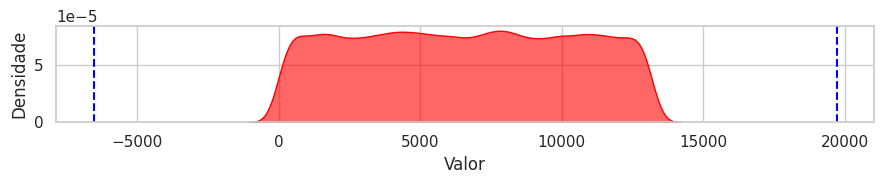

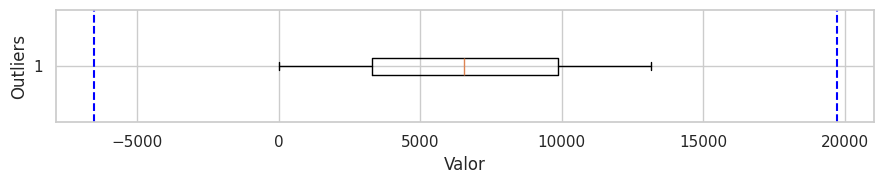

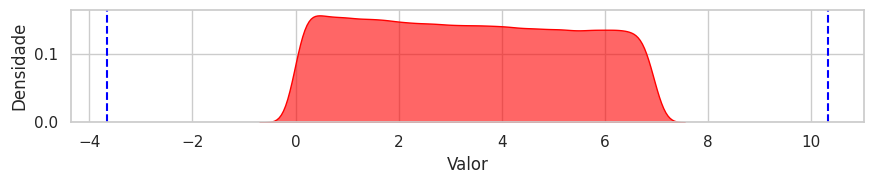

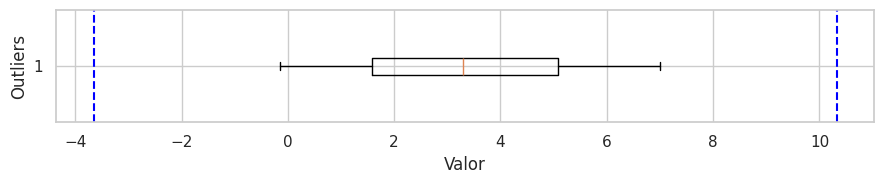

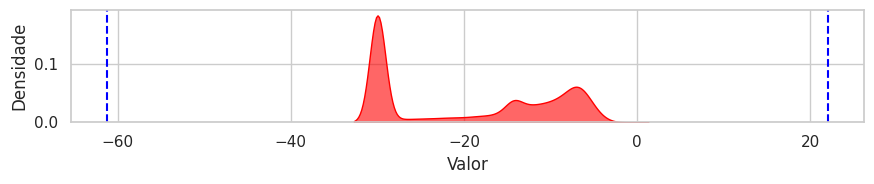

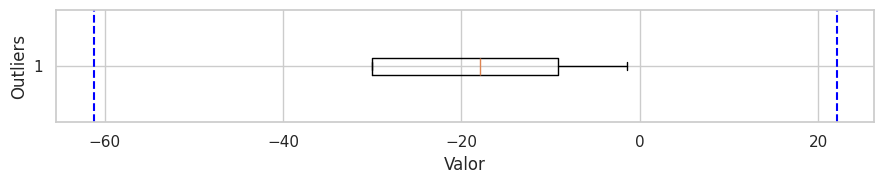

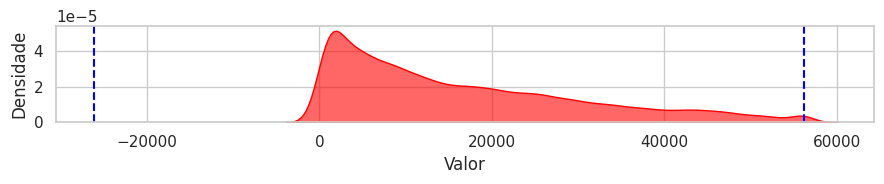

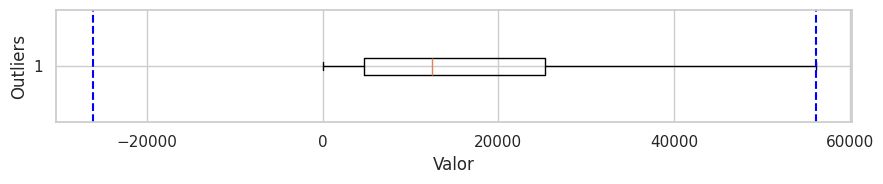

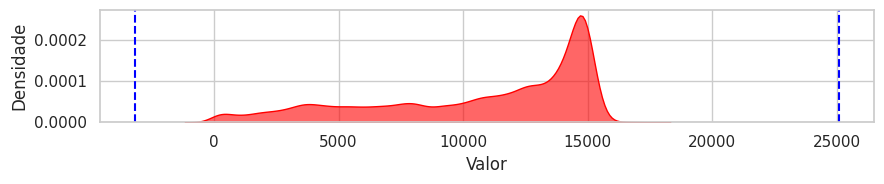

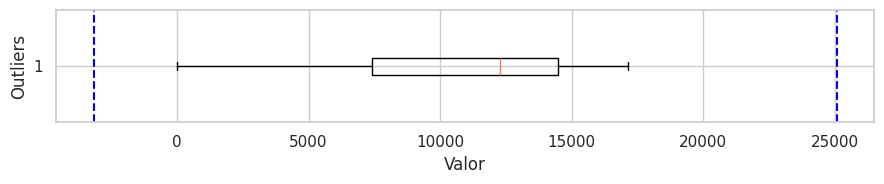

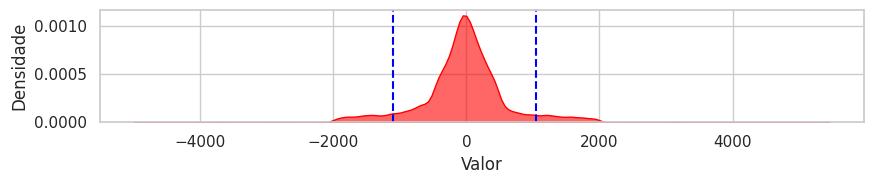

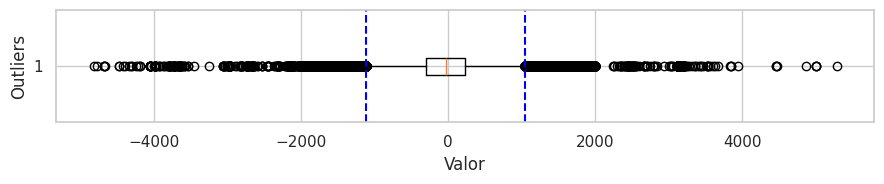

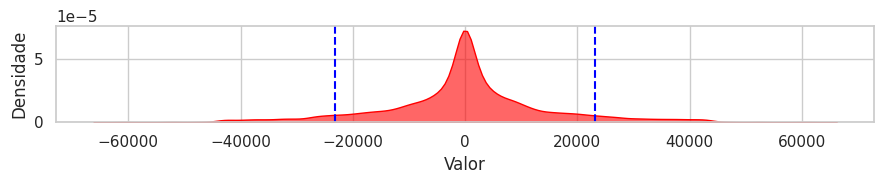

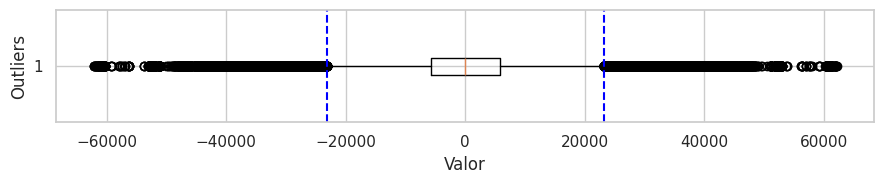

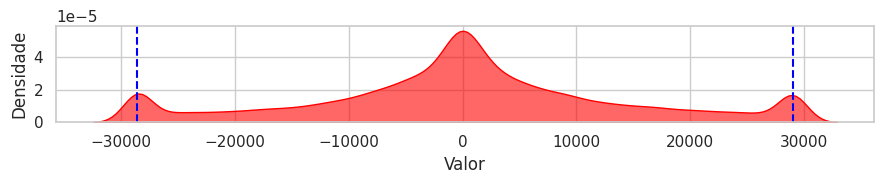

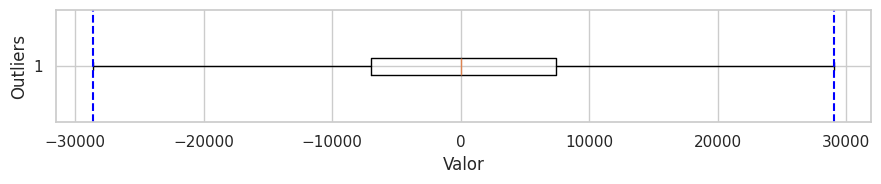

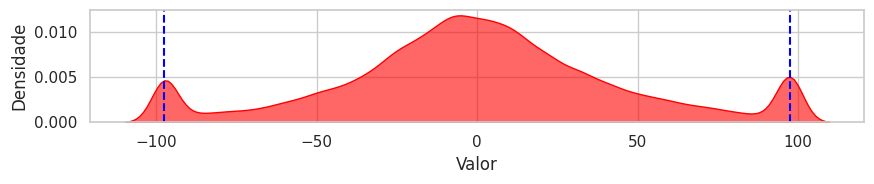

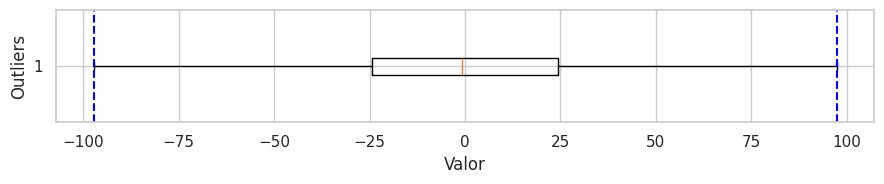

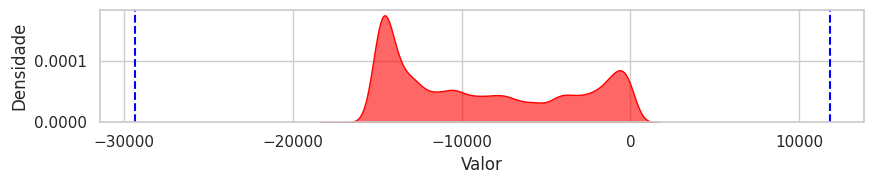

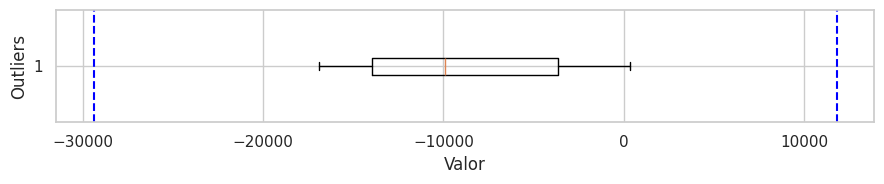

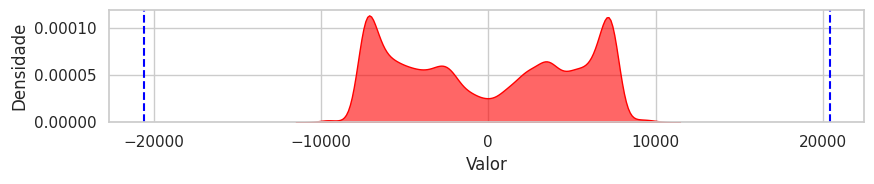

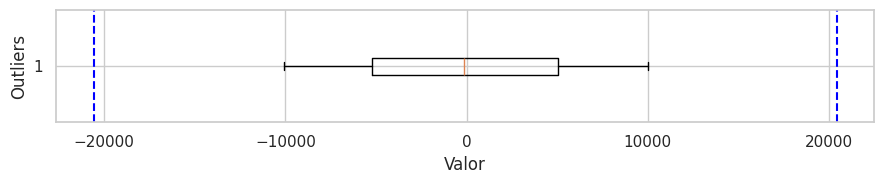

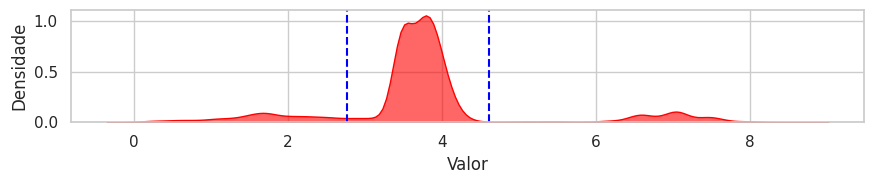

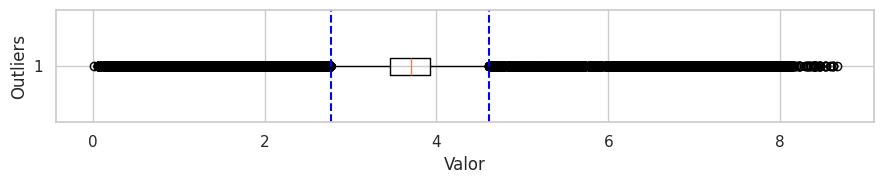

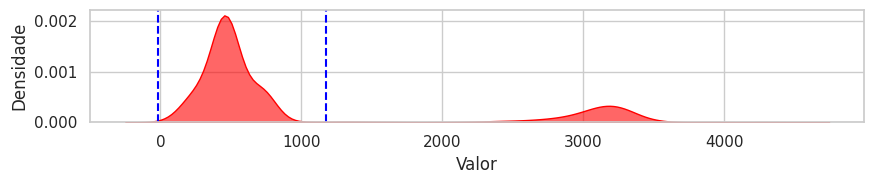

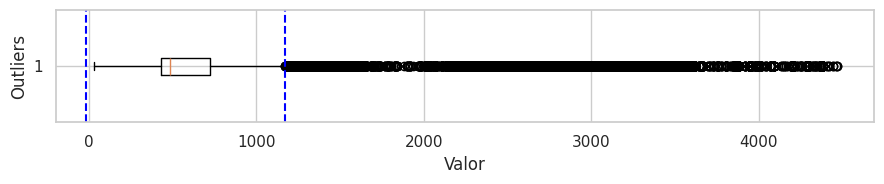

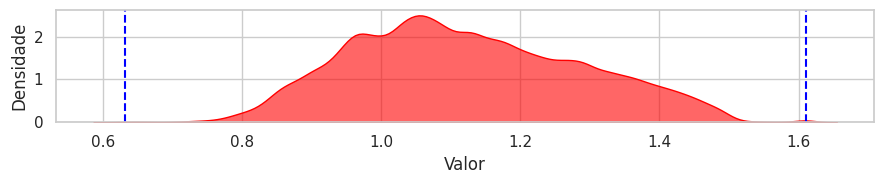

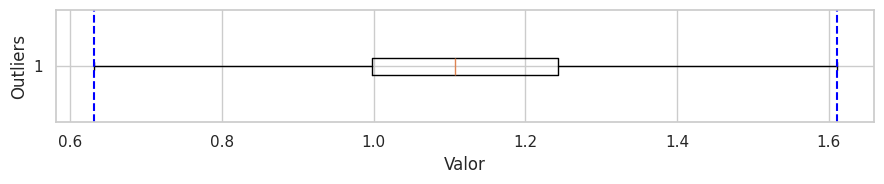

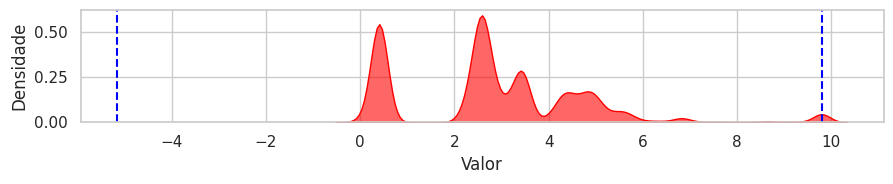

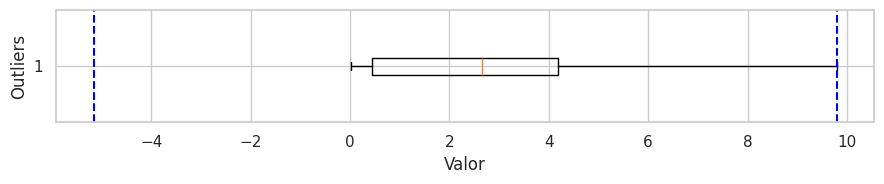

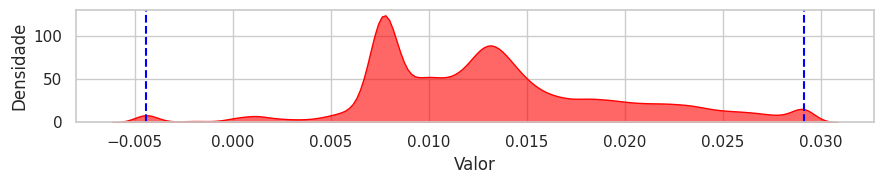

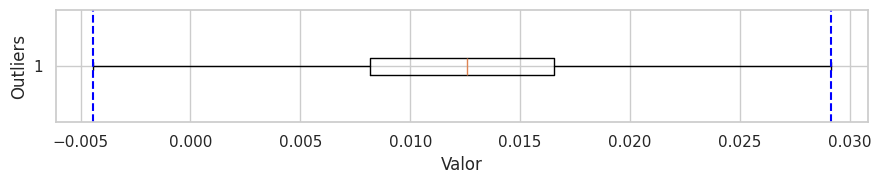

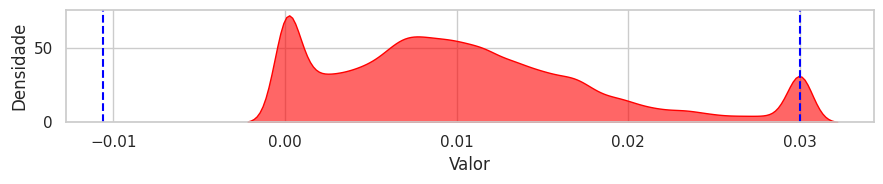

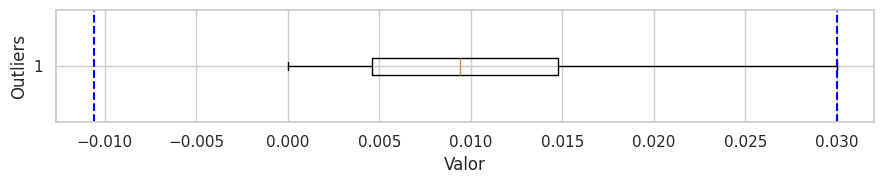

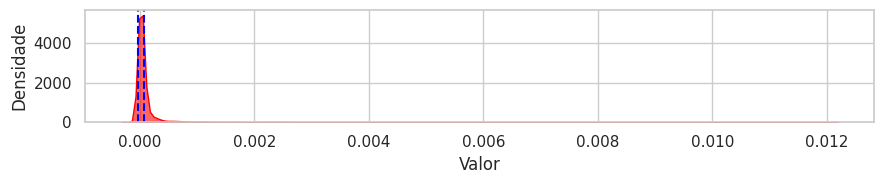

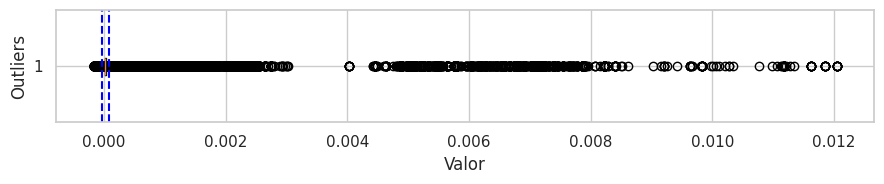

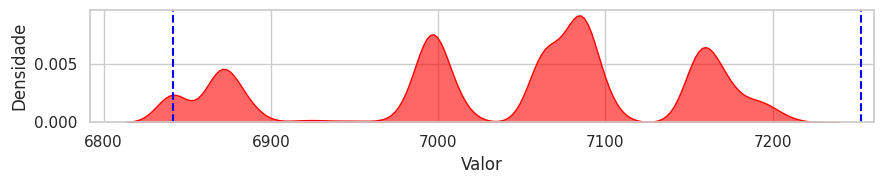

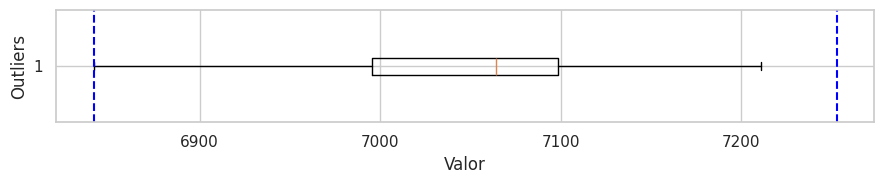

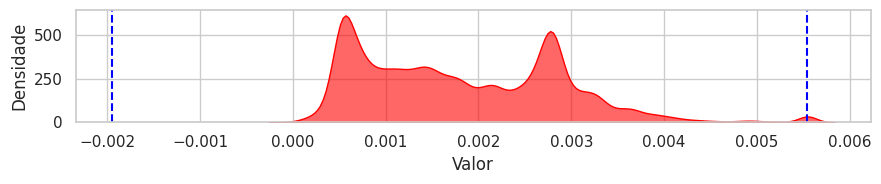

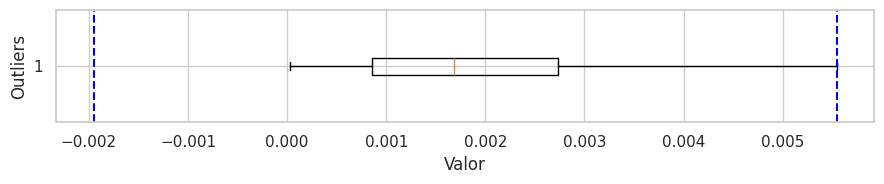

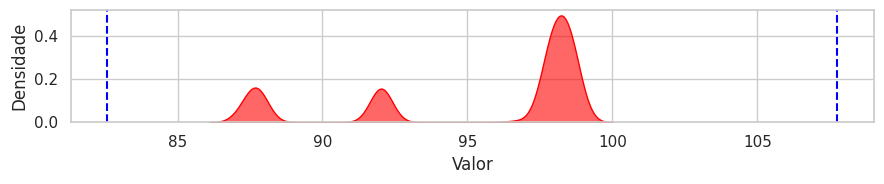

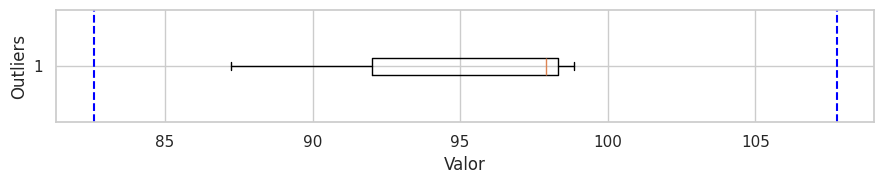

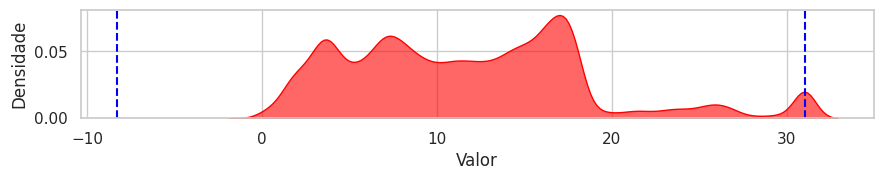

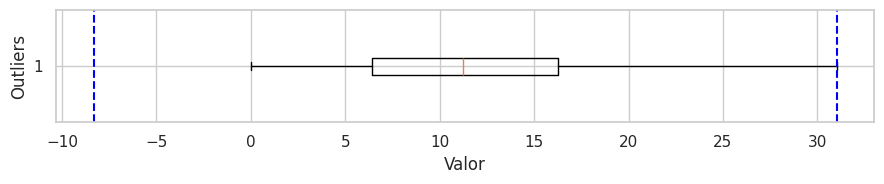

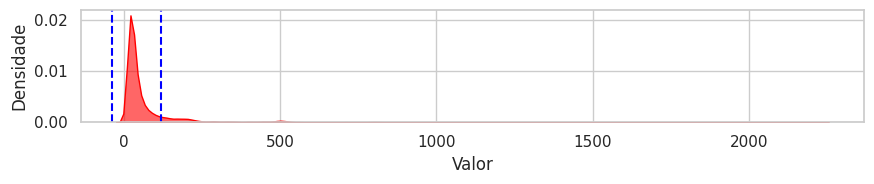

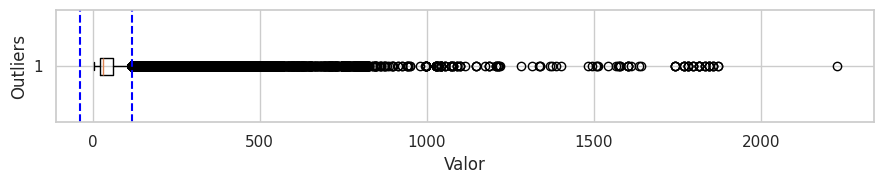

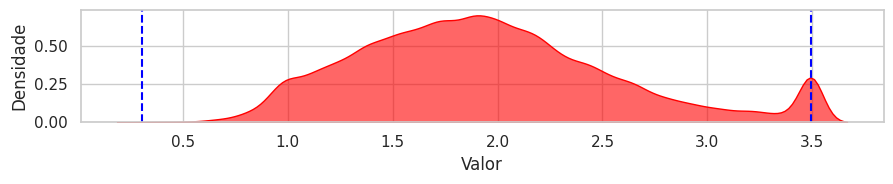

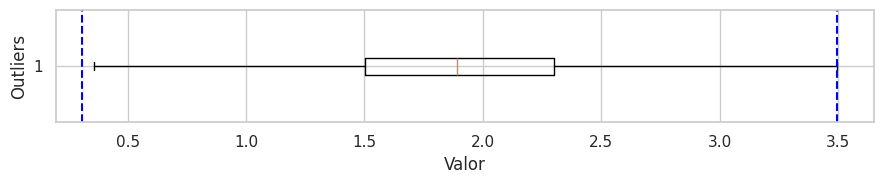

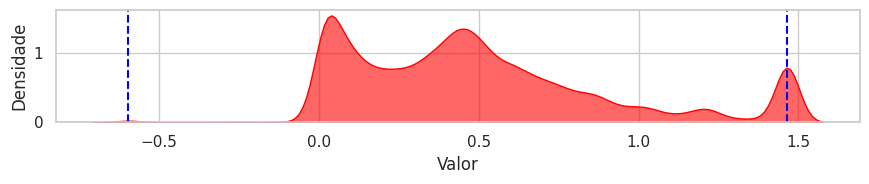

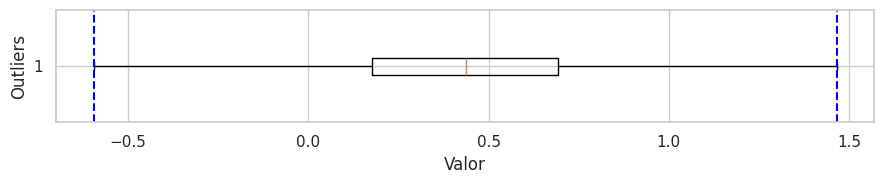

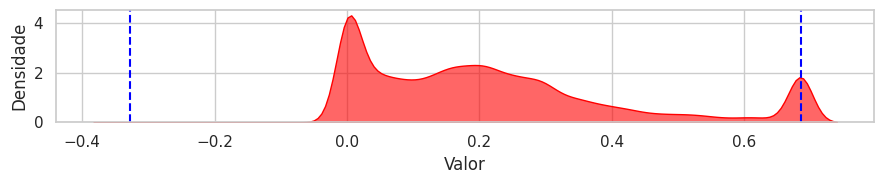

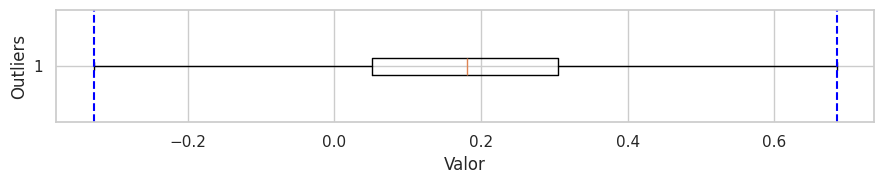

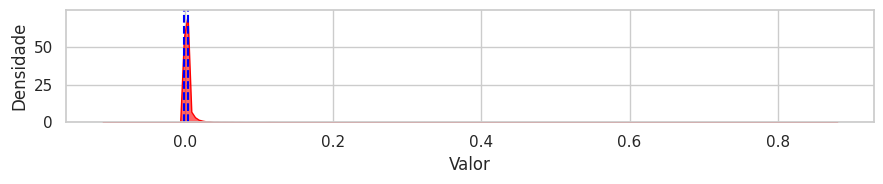

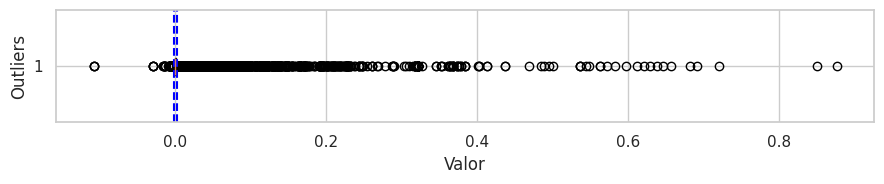

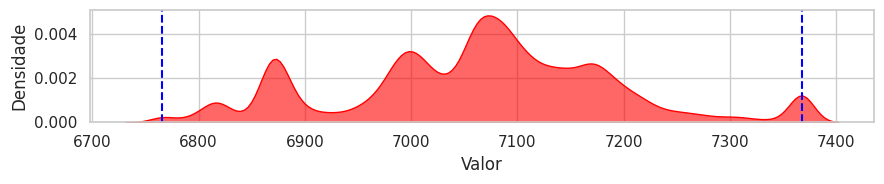

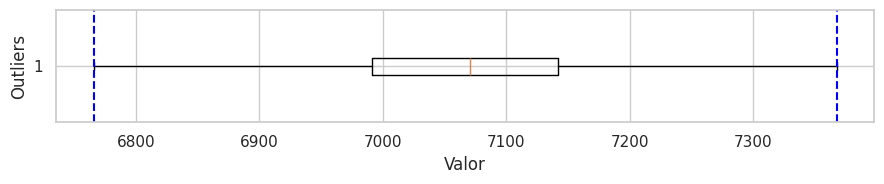

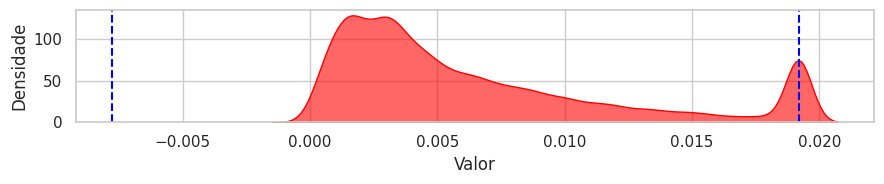

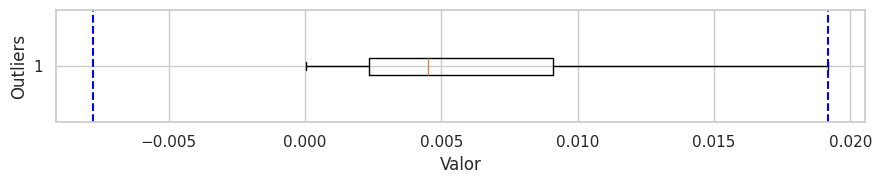

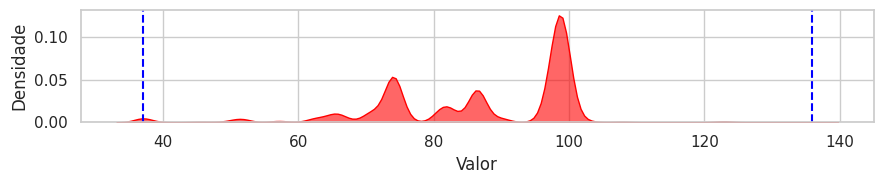

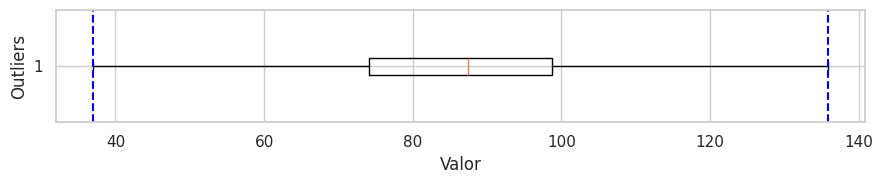

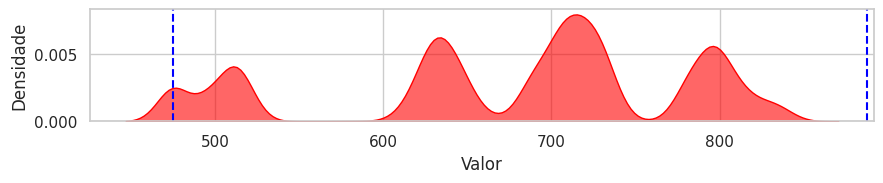

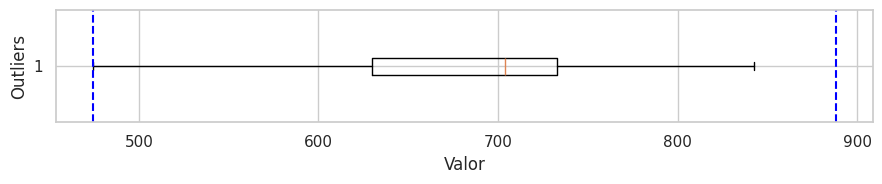

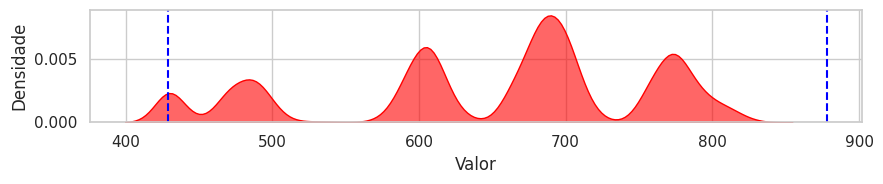

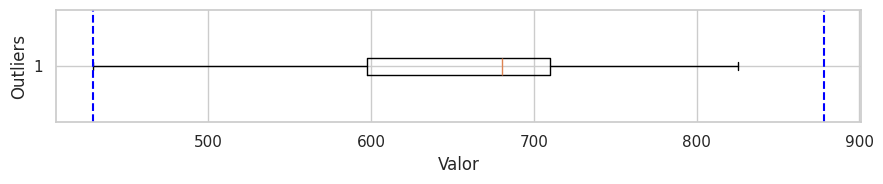

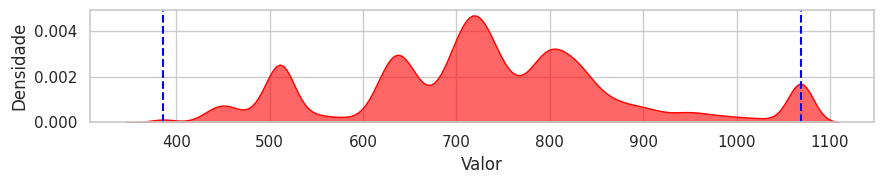

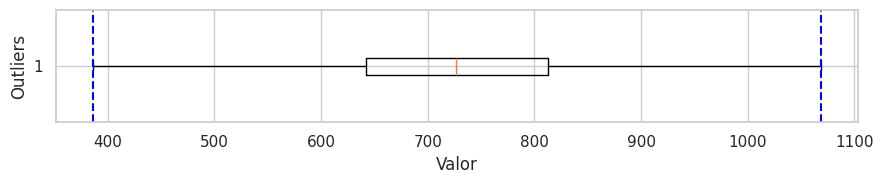

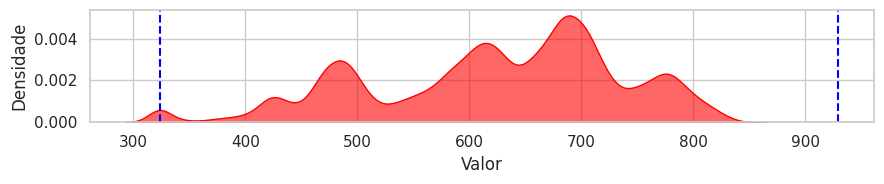

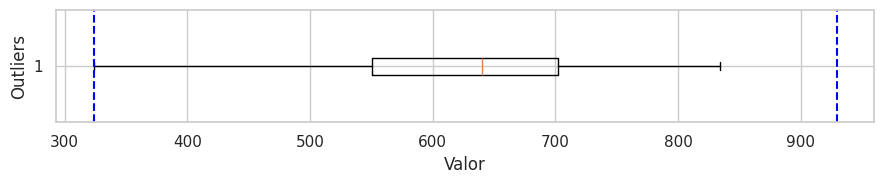

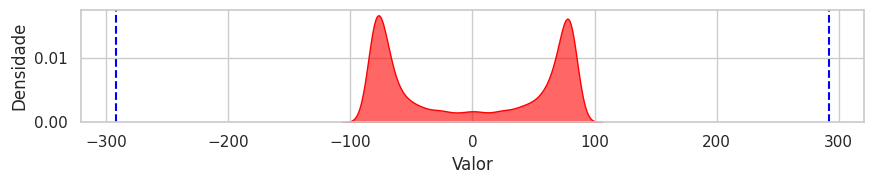

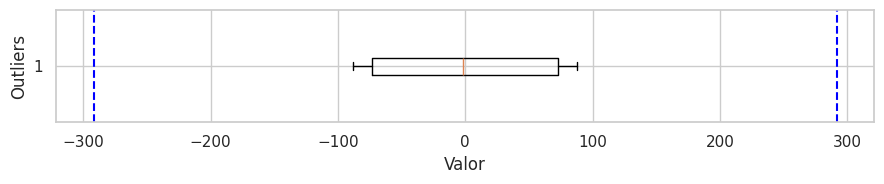

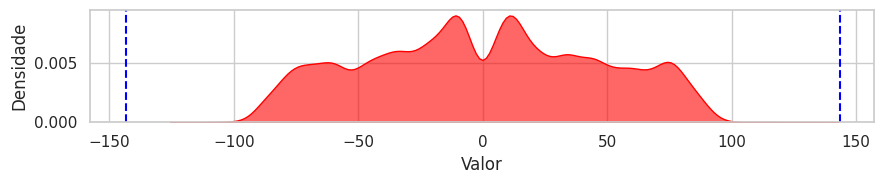

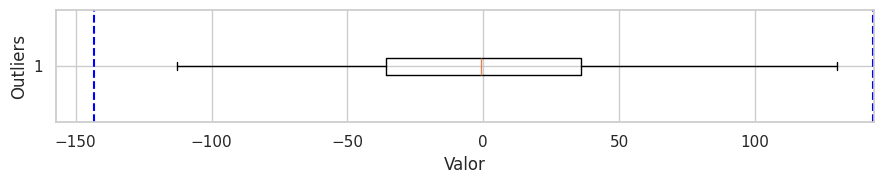

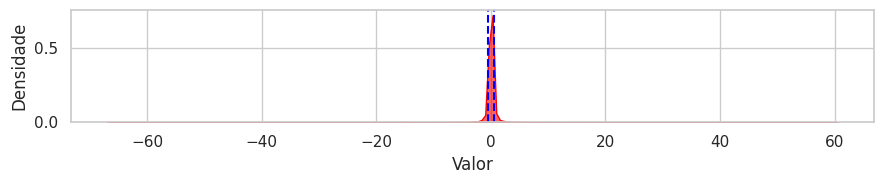

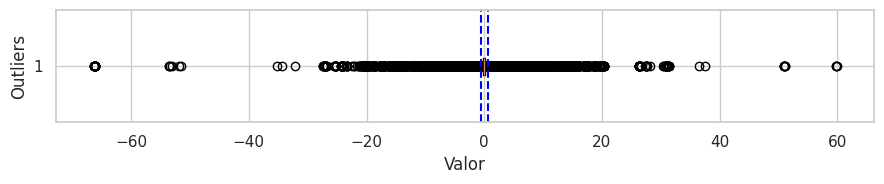

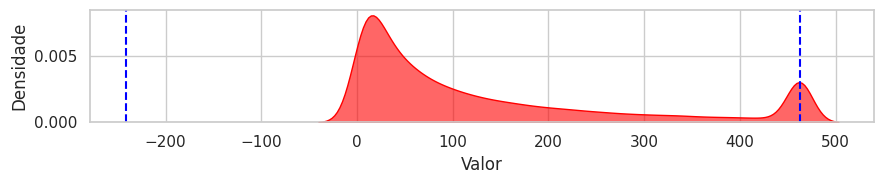

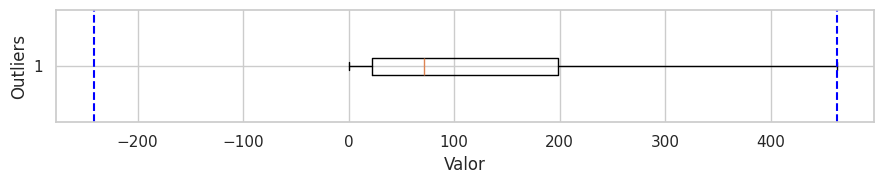

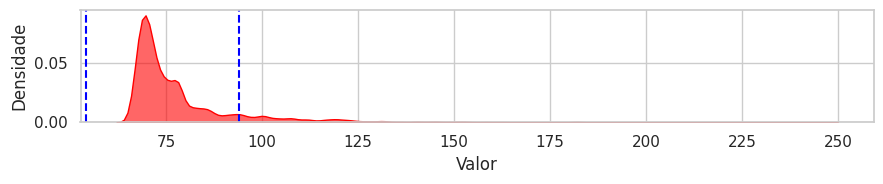

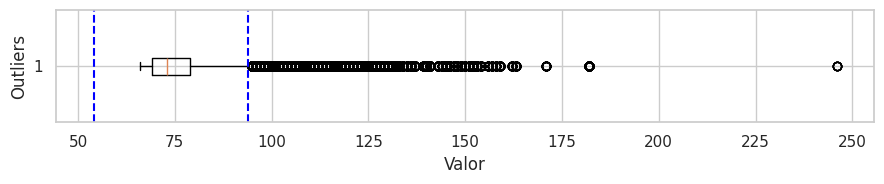

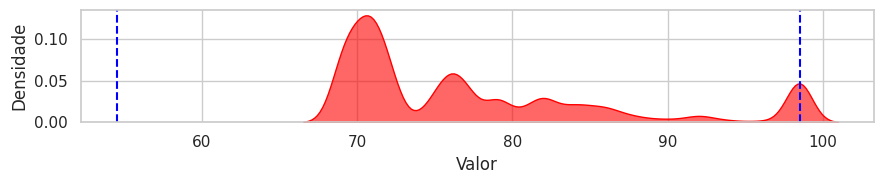

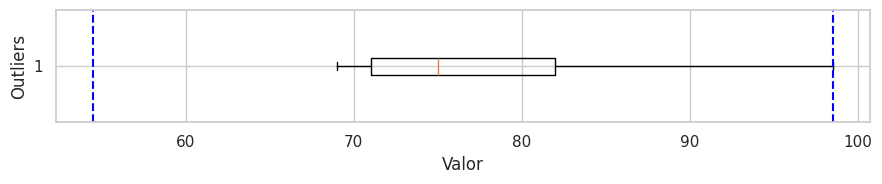

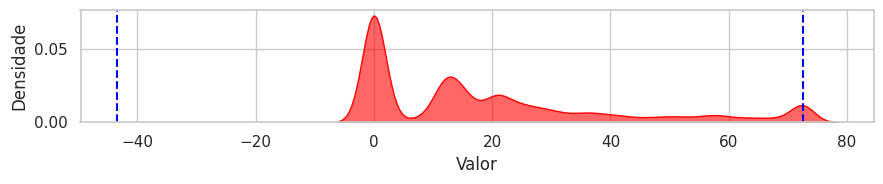

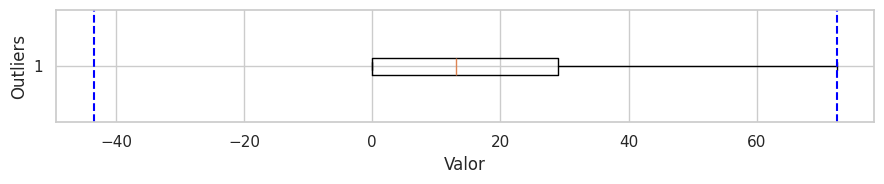

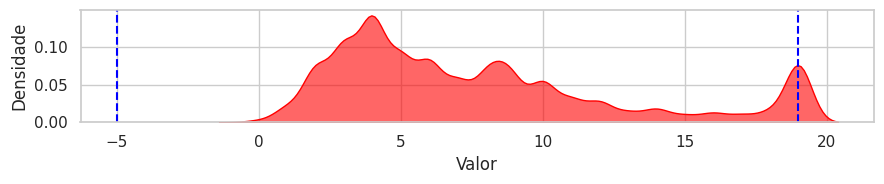

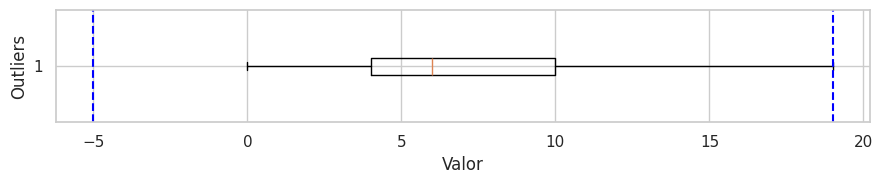

In [44]:
iqr_factor = get_config(eda_configs, 'iqr_factor')
outlier_summary = get_outliers(df, iqr_factor)

path = os.path.join(fig_path, 'outliers', 'after')
os.makedirs(path, exist_ok=True)

for col in outlier_summary.keys():
    plot_outliers(df[col], col, outlier_summary[col], path)

### Outliers Count and Percentage Table After Transformation

In [45]:
#iqr_factor = get_config(eda_configs, 'iqr_factor')
#outlier_summary = get_outliers(df, iqr_factor)

#file_path = os.path.join(tab_path, 'outliers', 'after')
#os.makedirs(file_path, exist_ok=True)
#plot_outliers_table(outlier_summary, "Final Outliers Summary", file_path)

## Unique Values Treatment

Display unique values percentage and remove columns with unique values percentage lower than a threshold.

In [46]:
def get_unique_values(df):
    unique_values = pd.DataFrame(
            {
            'Unique Values (%)': df.nunique() / len(df) * 100,
            }
        ).sort_values(['Unique Values (%)'], ascending=[False]
    )
    return unique_values

In [47]:
def plot_unique_values(unique_values, path):
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format): 
        fig, ax = plt.subplots(figsize=(20,8))
        unique_values.plot.bar(ax=ax, rot=80, grid=True, width=1.0)
        plt.xlabel("Coluna")
        plt.ylabel("Valores Únicos (%)")
        plt.legend().remove()
        ax.bar_label(ax.containers[0], fmt='{:,.3f}', label_type='edge', rotation=80)
        plt.tight_layout()
        plt.savefig(os.path.join(path, "unique_values.png"))
        plt.close(fig)
        plt.show()
        to_figure(os.path.join(path, "unique_values.png"), "Unique Values")

In [48]:
def plot_unique_values_table(unique_values, caption, file_path):
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format):
        display(unique_values)
        to_booktabs(
            unique_values,
            os.path.join(file_path, "unique_values.tex"),
            index=True,
            caption=caption,
            column_format='l' + 'c' * (len(unique_values.columns)),
        )

### Unique Values Before Filtering

In [49]:
path = os.path.join(fig_path, 'unique_values', 'before')
os.makedirs(path, exist_ok=True)

unique_values = get_unique_values(df)
plot_unique_values(unique_values, path)

### Drop Columns with Low Unique Values

Drop columns with low unique values.

In [50]:
def get_low_unique_values_columns_to_remove(df, UNIQUE_VALUES_THRESHOLD):
    unique_values = df.nunique() / len(df)
    is_low_unique_values = unique_values <= UNIQUE_VALUES_THRESHOLD
    cols_to_drop = set(unique_values[is_low_unique_values].index)
    cols_remove_data = [
        {
        'removed': col,
        'unique_values': unique_values[col],
        } for col in cols_to_drop]
    return cols_to_drop, cols_remove_data

In [51]:

unique_values_threshold = get_config(eda_configs, "low_unique_values_percent_threshold")
[cols_to_drop, cols_remove_data] = get_low_unique_values_columns_to_remove(df, unique_values_threshold)
should_keep = get_should_keep_columns(columns_config, cols_remove_data)

[df, cols_to_drop, cols_remove_data] = drop_columns(df, should_keep, cols_to_drop, cols_remove_data)
for col_data in cols_remove_data:
    col_name = get_column_name(col_data['removed'])
    col_path = find_col_path(columns_config, col_name)
    columns_config = update_config(columns_config, col_path, {
        'kept': False,
        'reason': f'low unique values, {col_data["unique_values"]:.3f} <= {unique_values_threshold:.3f}'
    })

update_yaml(columns_config)

### Unique Values After Filtering

In [52]:
path = os.path.join(fig_path, 'unique_values', 'after')
os.makedirs(path, exist_ok=True)

unique_values = get_unique_values(df)
plot_unique_values(unique_values, path)

## Low Variance Treatment

Display and drop columns with low variance.

In [53]:
def get_standard_deviations(df):
    stds = pd.DataFrame(
            {
            'Standard Deviation (%)': (df.std() / (df.max() - df.min())) * 100,
            }
        ).sort_values(['Standard Deviation (%)'], ascending=[False])
    return stds

In [54]:
def plot_standard_deviations_table(standard_deviations, caption, file_path):
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format):
        display(standard_deviations)
        to_booktabs(
            standard_deviations,
            os.path.join(file_path, "standard_deviations.tex"),
            index=True,
            caption=caption,
            column_format='l' + 'c' * (len(standard_deviations.columns)),
        )

In [55]:
def plot_standard_deviations(standard_deviations, path):
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format): 
        fig, ax = plt.subplots(figsize=(20,12))
        standard_deviations.plot.bar(ax=ax, rot=80, grid=True, width=1.0)
        plt.xlabel("Coluna")
        plt.ylabel("Desvio Padrão (%)")
        plt.legend().remove()
        ax.bar_label(ax.containers[0], fmt='{:,.3f}', label_type='edge', rotation=80)
        plt.tight_layout()
        plt.savefig(os.path.join(path, "standard_deviations.png"))
        plt.close(fig)
        to_figure(os.path.join(path, "standard_deviations.png"), "Standard Deviation")

### Variance Before Filtering

In [56]:
path = os.path.join(fig_path, 'standard_deviations', 'before')
os.makedirs(path, exist_ok=True)

standard_deviations = get_standard_deviations(df)
plot_standard_deviations(standard_deviations, path)

In [57]:
def get_low_variance_columns_to_remove(df, standard_deviations, var_threshold):
    is_low_variance = standard_deviations <= var_threshold * 100
    cols_to_drop = set(standard_deviations[is_low_variance].index)
    cols_remove_data = [
        {
        'removed': col,
        'standard_deviation': standard_deviations[col],
        'threshold': var_threshold * 100
        } for col in cols_to_drop]
    return cols_to_drop, cols_remove_data

In [58]:
var_threshold = get_config(eda_configs, "low_variance_percent_threshold")
standard_deviations = get_standard_deviations(df)
[cols_to_drop, cols_remove_data] = get_low_variance_columns_to_remove(df, standard_deviations['Standard Deviation (%)'], var_threshold)
should_keep = get_should_keep_columns(columns_config, cols_remove_data)

[df, cols_to_drop, cols_remove_data] = drop_columns(df, should_keep, cols_to_drop, cols_remove_data)
for col_data in cols_remove_data:
    col_name = get_column_name(col_data['removed'])
    col_path = find_col_path(columns_config, col_name)
    columns_config = update_config(columns_config, col_path, {
        'kept': False,
        'reason': f'low variance (std), {col_data["standard_deviation"]:.3f} <= {col_data["threshold"]:.3f}'
    })

update_yaml(columns_config)

### Variance After Filtering

In [59]:
path = os.path.join(fig_path, 'standard_deviations', 'after')
os.makedirs(path, exist_ok=True)

standard_deviations = get_standard_deviations(df)
plot_standard_deviations(standard_deviations, path)

## High Correlation Treatment

Remove columns with high correlation and display the heat map.

In [60]:
def get_correlation(df):
    df = df.sort_index(axis=1)
    return df.corr()

In [61]:
def plot_correlation_heatmap(corr, path):
    height = corr.shape[0] * 1.2
    width = corr.shape[1] * 1.5
    fig, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.savefig(os.path.join(path, 'correlation_heatmap.png'))
    plt.close(fig)
    plt.show()
    to_figure(os.path.join(path, 'correlation_heatmap.png'), "Correlation Heatmap")

### Heatmap Before Filtering

In [62]:
path = os.path.join(fig_path, 'correlation', 'before')
os.makedirs(path, exist_ok=True)

corr = get_correlation(df)
plot_correlation_heatmap(corr, path)

### Remove High Correlated Columns

In [63]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
THRESHOLD = get_config(eda_configs, 'high_correlation_threshold')

cols_to_drop = set()
removed_cols = []

for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        col_a = upper.columns[i]
        col_b = upper.columns[j]
        corr_value = upper.iloc[i, j]
        if corr_value >= THRESHOLD:
            cols_to_drop.add(col_b)
            removed_cols.append({
                'removed': col_b,
                'correlated': col_a,
                'correlation': corr_value
            })

should_keep = set()
new_removed_cols = []
def update_yaml_(config, removed_cols):
    for key, value in config.items():
        found = False
        for col in removed_cols:
            if key[2:] == col['removed'][2:]:
                if isinstance(value, dict):
                    if value.get('kept', False) == True:
                        should_keep.add(key)
                        if isinstance(config.get(col['correlated'], {}), dict):
                            if config.get(col['correlated'], {}).get('kept', False) == True:
                                should_keep.add(col['correlated'])
                                continue
                            else:
                                new_removed_cols.append({
                                    'removed': col['correlated'],
                                    'correlated': col['removed'],
                                    'correlation': col['correlation']   
                                })
                                break
                    else: 
                        config[key]['kept'] = False
                        config[key]['reason'] = f'multicoliniarity with column {col["correlated"]} ({col["correlation"]:.3f})'
                        found = True
                        break
        
        if not found:
            if (isinstance(value, dict)):
                config[key] = update_yaml_(value, removed_cols)

    return config

with open(filtered_path, 'r') as f:
    columns_config = yaml.safe_load(f)
    columns_config['columns'] = update_yaml_(columns_config['columns'], removed_cols)
    columns_config['columns'] = update_yaml_(columns_config['columns'], new_removed_cols)

with open(filtered_path, 'w+') as f:
    yaml.dump(columns_config, f)

df = df.drop(columns=list(cols_to_drop - should_keep))

### Heatmap After Filtering

In [64]:
path = os.path.join(fig_path, 'correlation', 'after-filtering')
os.makedirs(path, exist_ok=True)

corr = get_correlation(df)
plot_correlation_heatmap(corr, path)

## Low Correlation with Risk

In [65]:
def get_correlation_with_risk(df):
    return df.corrwith(df['risk']).abs().sort_values(ascending=False).drop('event_id')

In [66]:
def plot_correlation_with_risk(corr_with_risk, path):
    corr_with_risk = corr_with_risk.drop('risk')
    with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.3f}'.format): 
        fig, ax = plt.subplots(figsize=(10, 5))
        corr_with_risk.plot.bar(ax=ax, rot=80, grid=True, width=0.7)
        plt.xlabel("Coluna")
        plt.ylabel("Correlação")
        ax.bar_label(ax.containers[0], fmt='{:,.3f}', label_type='edge', rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'correlation_with_risk.png'))
        plt.show()
        plt.close(fig)
        to_figure(os.path.join(path, 'correlation_with_risk.png'), "Correlation with risk")


### Bar Chart Before Filtering

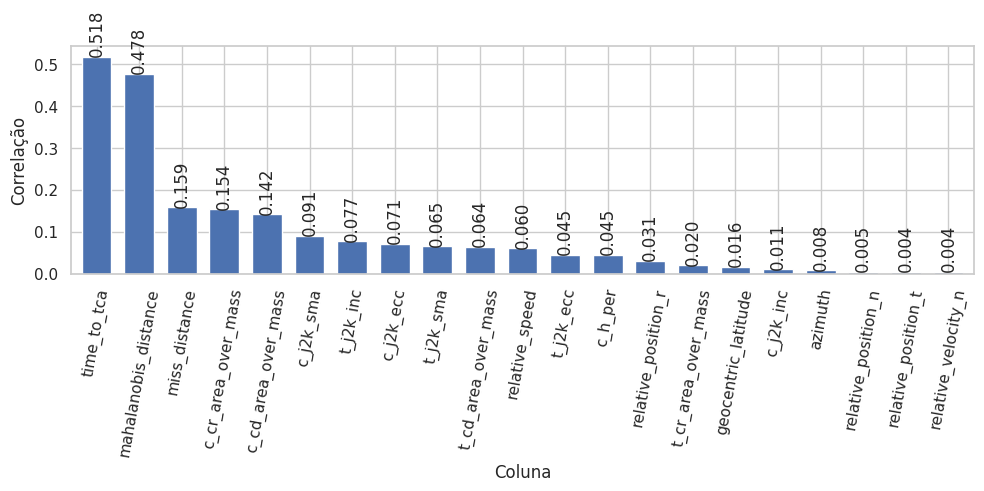

In [67]:
path = os.path.join(fig_path, 'correlation-with-risk', 'before')
os.makedirs(path, exist_ok=True)

corr_with_risk = get_correlation_with_risk(df)
plot_correlation_with_risk(corr_with_risk, path)

### Remove Low Correlated Columns

Remove columns with low correlation with risk

In [68]:
def get_low_correlation_cols(df, low_risk_correlation_threshold):
    corr_series = df.drop(columns=['risk']).corrwith(df['risk']).abs()
    is_low_correlation = corr_series <= low_risk_correlation_threshold
    cols_to_drop = set(corr_series[is_low_correlation].index)
    cols_remove_data = [
        {
            'removed': col,
            'correlation': corr_series[col],
        } for col in cols_to_drop
    ]
    return cols_to_drop, cols_remove_data

In [69]:
low_risk_correlation_threshold = get_config(eda_configs, 'low_risk_correlation_threshold')
[cols_to_drop, cols_remove_data] = get_low_correlation_cols(df, low_risk_correlation_threshold)
should_keep = get_should_keep_columns(columns_config, cols_remove_data)

[df, cols_to_drop, cols_remove_data] = drop_columns(df, should_keep, cols_to_drop, cols_remove_data)
for col_data in cols_remove_data:
    col_name = get_column_name(col_data['removed'])
    col_path = find_col_path(columns_config, col_name)
    columns_config = update_config(columns_config, col_path, {
        'kept': False,
        'reason': f'low correlation with risk, {col_data["correlation"]:.3f} <= {low_risk_correlation_threshold:.3f}'
    })

update_yaml(columns_config)

### Bar Chart After Filtering

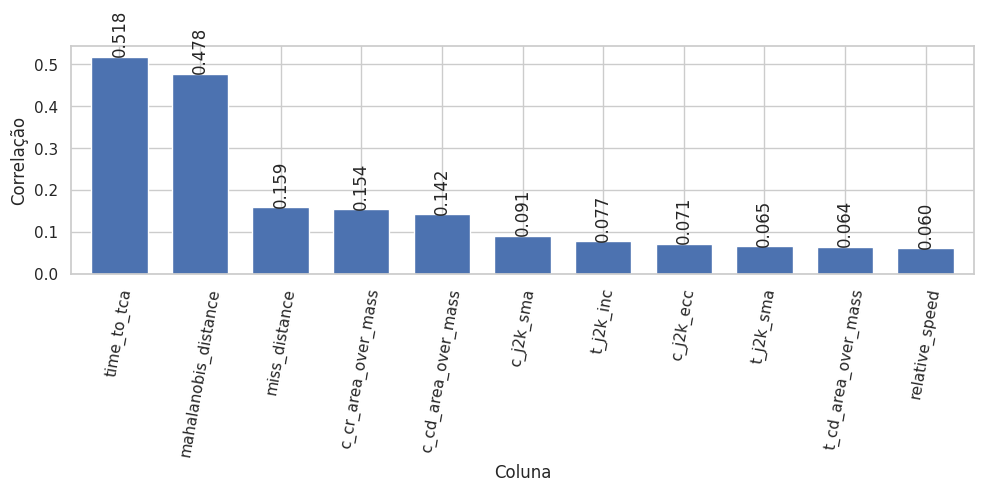

In [70]:
path = os.path.join(fig_path, 'correlation-with-risk', 'after-low-correlated-removal')
os.makedirs(path, exist_ok=True)

corr_with_risk = get_correlation_with_risk(df)
plot_correlation_with_risk(corr_with_risk, path)

## Similar Correlation with Risk Treatment

### Remove Columns with Similar Correlation with Risk

In [71]:
corr_with_risk = df.drop(columns=['risk']).corrwith(df['risk']).abs().sort_values(ascending=False)
    
TOLERANCE_THRESHOLD = get_config(eda_configs, 'similar_risk_correlation_threshold')

cols_to_drop = set()
removed_cols = []

def remove_redundant_cols(corr_with_risk):
    for col_a, corr_a in corr_with_risk.items():
        for col_b, corr_b in corr_with_risk.items():
            if col_a == col_b:
                continue
            if abs(corr_a - corr_b) <= TOLERANCE_THRESHOLD:
                if col_a in cols_to_drop or col_b in cols_to_drop:
                    continue
                if corr_a >= corr_b:
                    cols_to_drop.add(col_b)
                    removed_cols.append({
                        'removed': col_b,
                        'removed_corr': corr_b,
                        'correlated': col_a,
                        'correlated_corr': corr_a
                    })
                else:
                    cols_to_drop.add(col_a)
                    removed_cols.append({
                        'removed': col_b,
                        'removed_corr': corr_b,
                        'correlated': col_a,
                        'correlated_corr': corr_a
                    })

    return cols_to_drop

cols_to_drop = remove_redundant_cols(corr_with_risk)

should_keep = set()
new_removed_cols = []

def update_yaml_(config, removed_cols):
    for key, value in config.items():
        found = False
        for col in removed_cols:
            if key[2:] == col['removed'][2:]:
                if isinstance(value, dict):
                    if value.get('kept', False) == True:
                        should_keep.add(key)
                        if isinstance(config.get(col['correlated'], {}), dict):
                            if config.get(col['correlated'], {}).get('kept', False) == True:
                                should_keep.add(col['correlated'])
                                continue
                            else:
                                new_removed_cols.append({
                                    'removed': col['correlated'],
                                    'removed_corr': col['correlated_corr'],
                                    'correlated': col['removed'],
                                    'correlated_corr': col['removed_corr']
                                })
                                break
                    else:         
                        config[key]['kept'] = False
                        config[key]['reason'] = f'similar risk correlation ({col['removed_corr']:.3f}) with column {col['correlated']} ({col['correlated_corr']:.3f})'
                        found = True
                        break
        
        if not found:
            if (isinstance(value, dict)):
                config[key] = update_yaml_(value, removed_cols)

    return config

with open(filtered_path, 'r') as f:
    columns_config = yaml.safe_load(f)
    columns_config['columns'] = update_yaml_(columns_config['columns'], removed_cols)
    columns_config['columns'] = update_yaml_(columns_config['columns'], new_removed_cols)

with open(filtered_path, 'w+') as f:
    yaml.dump(columns_config, f)

df = df.drop(columns=list(cols_to_drop - should_keep))

### Bar Chart After Filtering

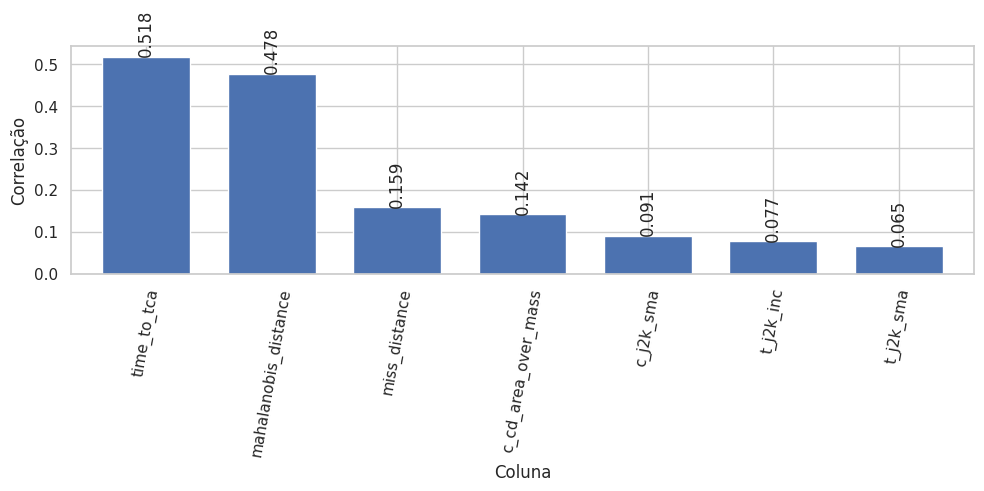

In [72]:
path = os.path.join(fig_path, 'correlation-with-risk', 'after-similarity-removal')
os.makedirs(path, exist_ok=True)

corr_with_risk = get_correlation_with_risk(df)
plot_correlation_with_risk(corr_with_risk, path)

# Updated Columns

## Updated Columns Statistics

In [73]:
file_path = os.path.join(tab_path, 'columns_stats', 'final')
os.makedirs(file_path, exist_ok=True)
display_columns_stats(df, "Final Columns Basic Statistics", file_path)

mean        std       min       25%        50%  \
c_cd_area_over_mass       0.503      0.408    -0.596     0.177      0.439   
c_j2k_sma             7,063.215    126.190 6,765.823 6,991.471  7,070.527   
event_id              6,566.872  3,798.407     0.000 3,306.000  6,558.000   
mahalanobis_distance    135.023    147.862     0.000    22.406     71.170   
miss_distance        16,500.265 14,175.605     9.000 4,683.000 12,439.000   
risk                    -19.341     10.012   -30.000   -30.000    -17.871   
t_j2k_inc                95.409      4.207    87.237    92.024     97.893   
t_j2k_sma             7,041.684    103.070 6,841.271 6,995.626  7,064.011   
time_to_tca               3.350      2.013    -0.150     1.588      3.298   

                            75%        max  
c_cd_area_over_mass       0.693      1.466  
c_j2k_sma             7,141.904  7,367.552  
event_id              9,867.000 13,153.000  
mahalanobis_distance    198.477    462.583  
miss_distance        25,281.000 56,178.000  
risk                     -9.173     -1.443  
t_j2k_inc                98.319     98.848  
t_j2k_sma             7,098.529  7,211.095  
time_to_tca               5.084      6.994

## Updated Outliers

Count     %  Lower Bound  Upper Bound
event_id                  0 0.000   -6,535.500   19,708.500
time_to_tca               0 0.000       -3.655       10.327
risk                      0 0.000      -61.240       22.067
miss_distance             0 0.000  -26,214.000   56,178.000
t_j2k_sma                 0 0.000    6,841.271    7,252.884
t_j2k_inc                 0 0.000       82.581      107.762
c_cd_area_over_mass       0 0.000       -0.596        1.466
c_j2k_sma                 0 0.000    6,765.823    7,367.552
mahalanobis_distance      0 0.000     -241.701      462.583

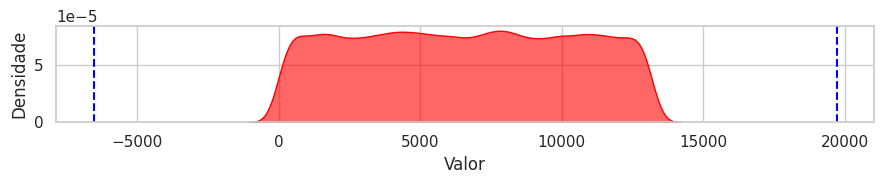

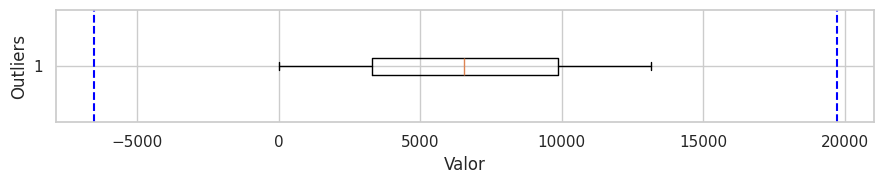

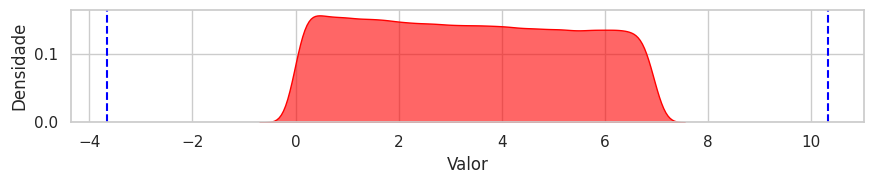

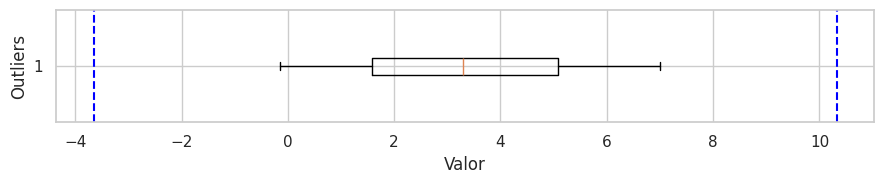

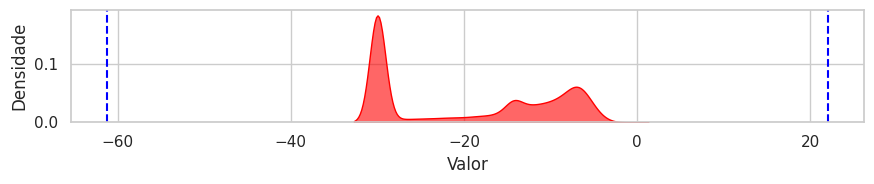

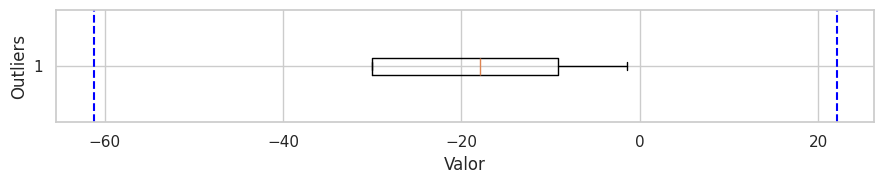

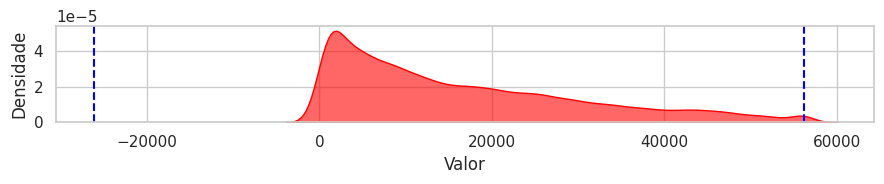

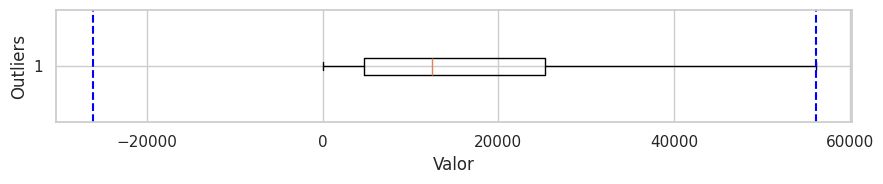

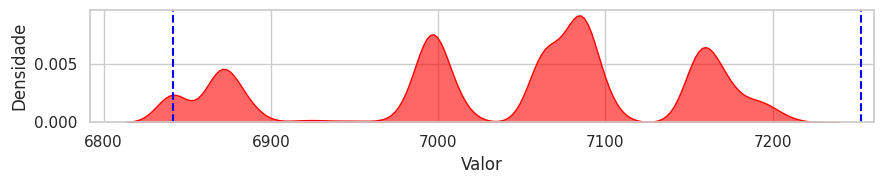

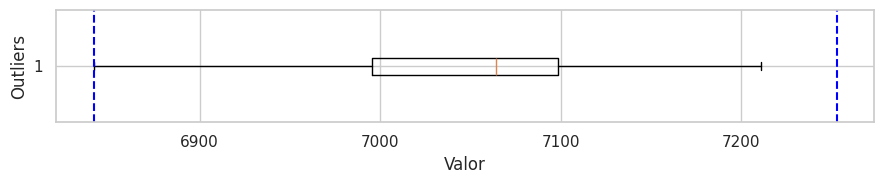

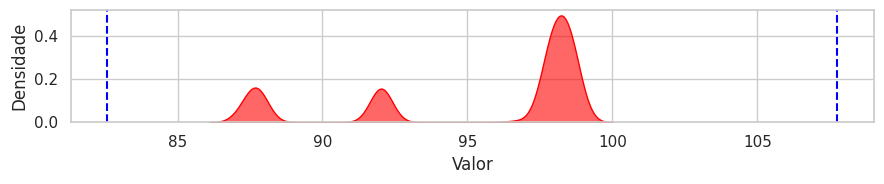

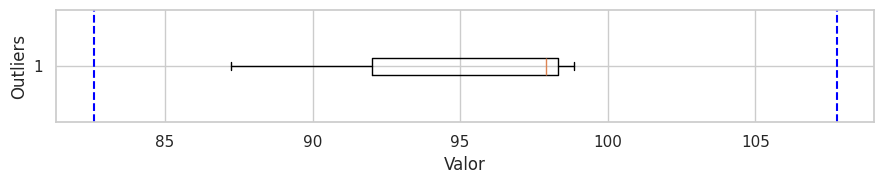

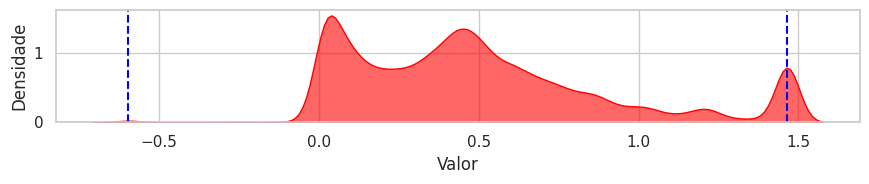

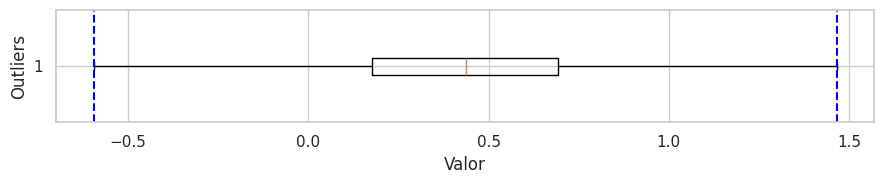

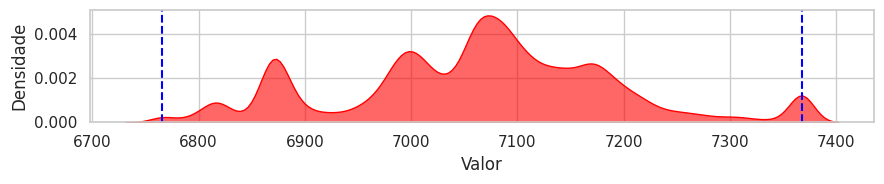

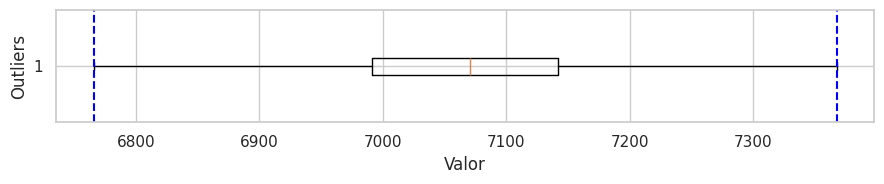

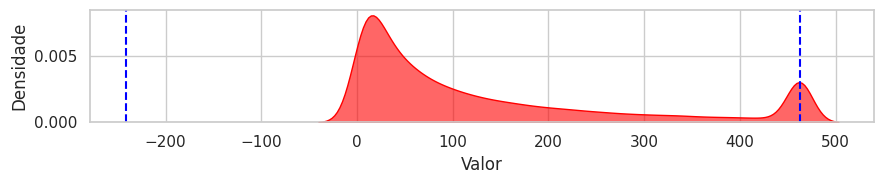

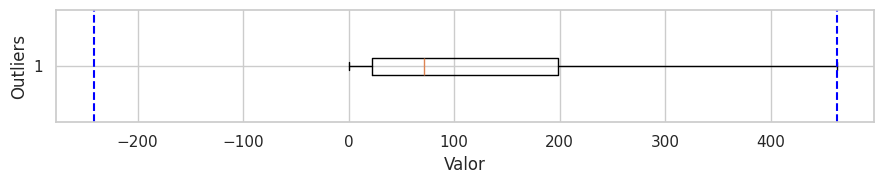

In [74]:
iqr_factor = get_config(eda_configs, 'iqr_factor')
outlier_summary = get_outliers(df, iqr_factor)

file_path = os.path.join(tab_path, 'outliers', 'updated')
os.makedirs(file_path, exist_ok=True)
plot_outliers_table(outlier_summary, "Final Outliers Summary", file_path)

file_path = os.path.join(fig_path, 'outliers', 'updated')
os.makedirs(file_path, exist_ok=True)
for col in outlier_summary.keys():
    plot_outliers(df[col], col, outlier_summary[col], file_path)

## Updated Correlation Heatmap

In [75]:
path = os.path.join(fig_path, 'correlation', 'updated-heatmap')
os.makedirs(path, exist_ok=True)

corr = get_correlation(df)
plot_correlation_heatmap(corr, path)

## Updated Correlation With Risk

risk                    1.000000
time_to_tca             0.518096
mahalanobis_distance    0.477614
miss_distance           0.158842
c_cd_area_over_mass     0.142209
c_j2k_sma               0.090659
t_j2k_inc               0.077279
t_j2k_sma               0.064633
dtype: float64

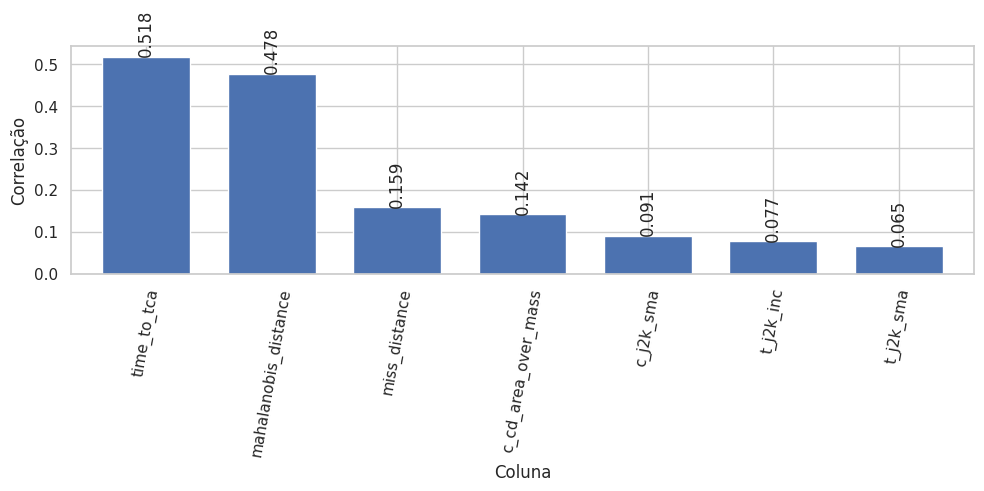

In [76]:
path = os.path.join(fig_path, 'correlation-with-risk', 'updated')
os.makedirs(path, exist_ok=True)

corr_with_risk = get_correlation_with_risk(df)
display(corr_with_risk)
plot_correlation_with_risk(corr_with_risk, path)

# Timeseries Visualizations

## Select events with a minimum number of entries (CDMs)

In [77]:
N_EVENTS_TO_PLOT = get_config(eda_configs, 'n_events_to_plot')
MIN_ENTRIES_THRESHOLD = get_config(eda_configs, 'min_entries_threshold')
FIRST_EVENT_TO_PLOT = get_config(eda_configs, 'first_event_to_plot')

qualified_events = df['event_id'].value_counts()[df['event_id'].value_counts() >= MIN_ENTRIES_THRESHOLD].index
if len(qualified_events) > N_EVENTS_TO_PLOT:
    sample_ids = qualified_events[FIRST_EVENT_TO_PLOT:FIRST_EVENT_TO_PLOT + N_EVENTS_TO_PLOT] 
else:
    sample_ids = qualified_events

df_plot = df[df['event_id'].isin(sample_ids)].copy()

## Remove columns that do not make sense to be plotted

Filter columns that doesn't make sense to be plotted on timeseries

In [78]:
def filter_timeseries_columns_dont_plot(df, columns_config):
    cols_to_drop = set()
    for col in df.columns:
        configs = get_config(columns_config, col)
        if configs.get('timeseries_plot', False) == False:
            cols_to_drop.add(col)
    cols_to_drop.remove('event_id')
    cols_to_drop.remove('time_to_tca')
    df = df.drop(columns=cols_to_drop)
    return df

In [79]:
df_plot = filter_timeseries_columns_dont_plot(df_plot, columns_config)

## Plot the selected events for the relevant columns (not removed)

In [80]:
def plot_timeseries(df, column_name, n_events_to_plot, path):
    height = df.shape[0] / 20
    width = df.shape[1] * 3
    fig, ax = plt.subplots(figsize=(width, height))
    sns.lineplot(
        data=df,
        x='time_to_tca',
        y=column_name,
        hue='event_id',
        marker='o',
        alpha=0.8,
        palette=sns.color_palette('husl', n_events_to_plot)
    )

    plt.gca().invert_xaxis()
    ax.set_xlabel("Tempo para o TCA (dias)")
    ax.set_ylabel(column_name)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    ax.legend(title='Event ID', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.savefig(os.path.join(path, f"timeseries_{column_name}.png"))
    plt.show()
    plt.close(fig)
    to_figure(os.path.join(path, f"timeseries_{column_name}.png"), f"Timeseries for column {col}")

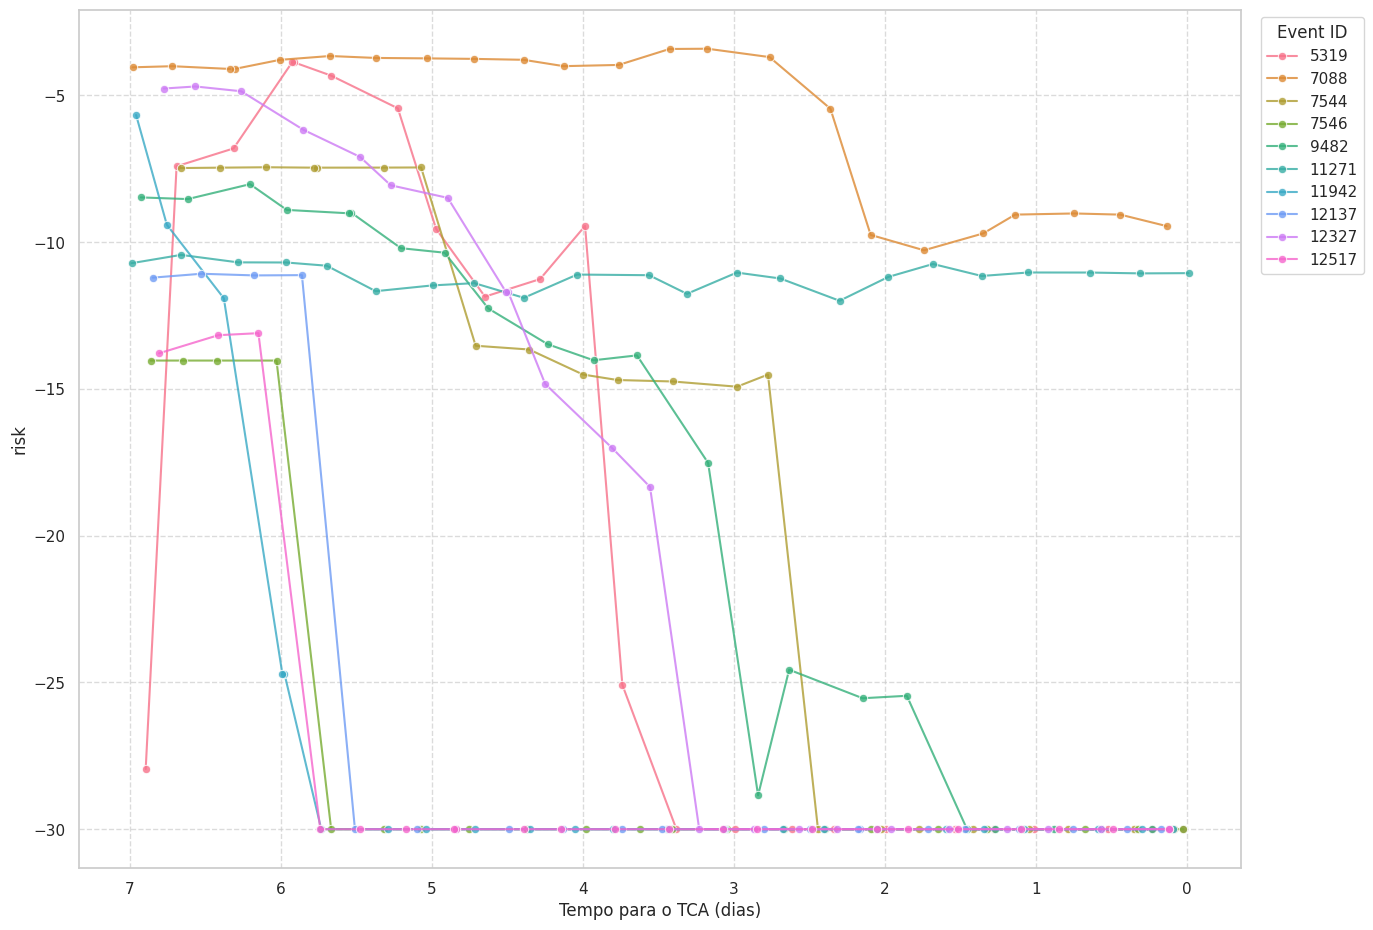

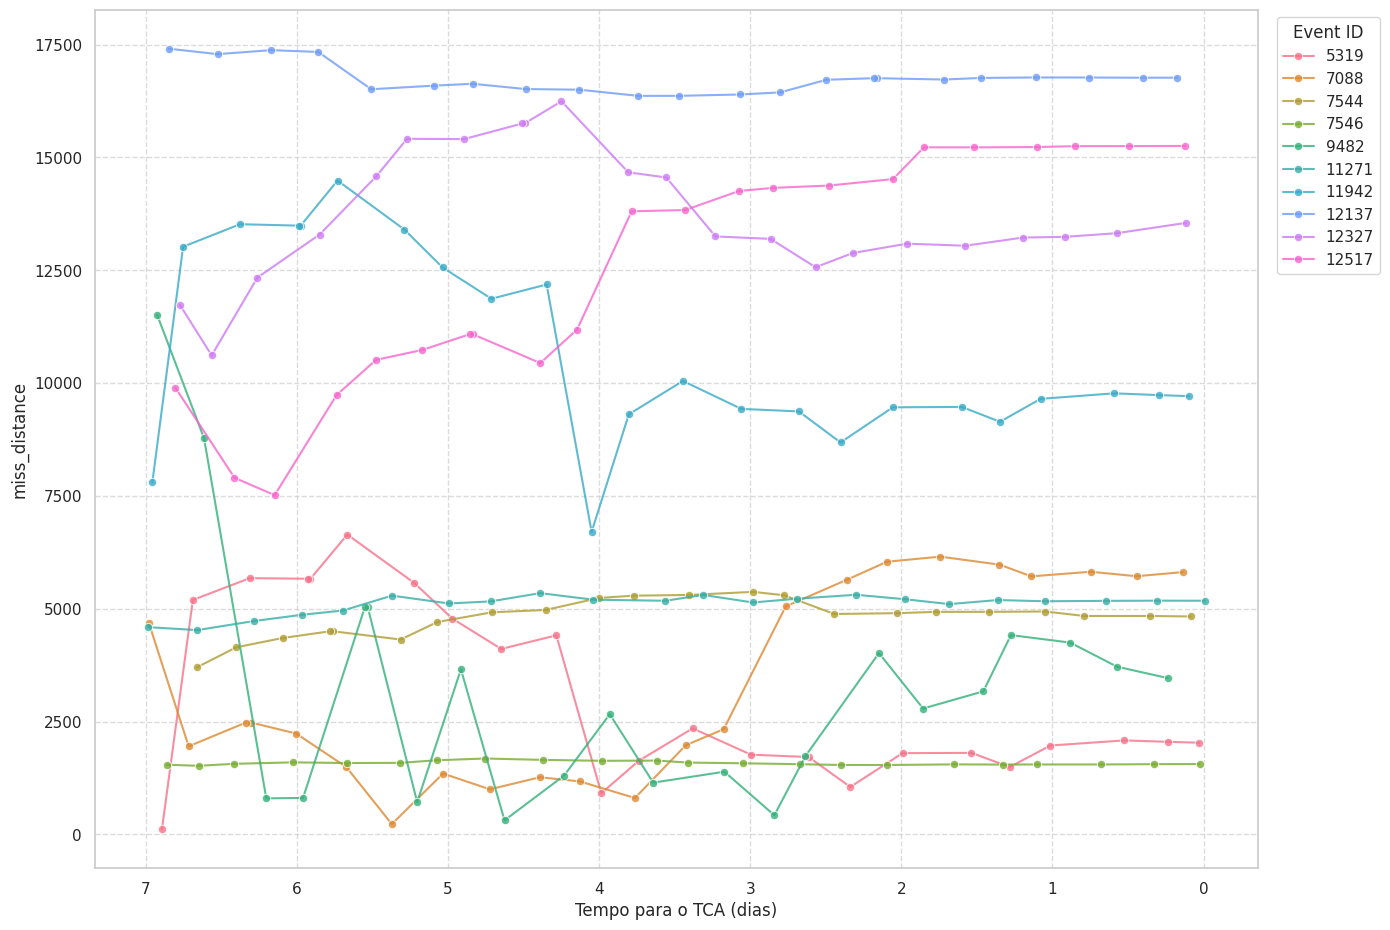

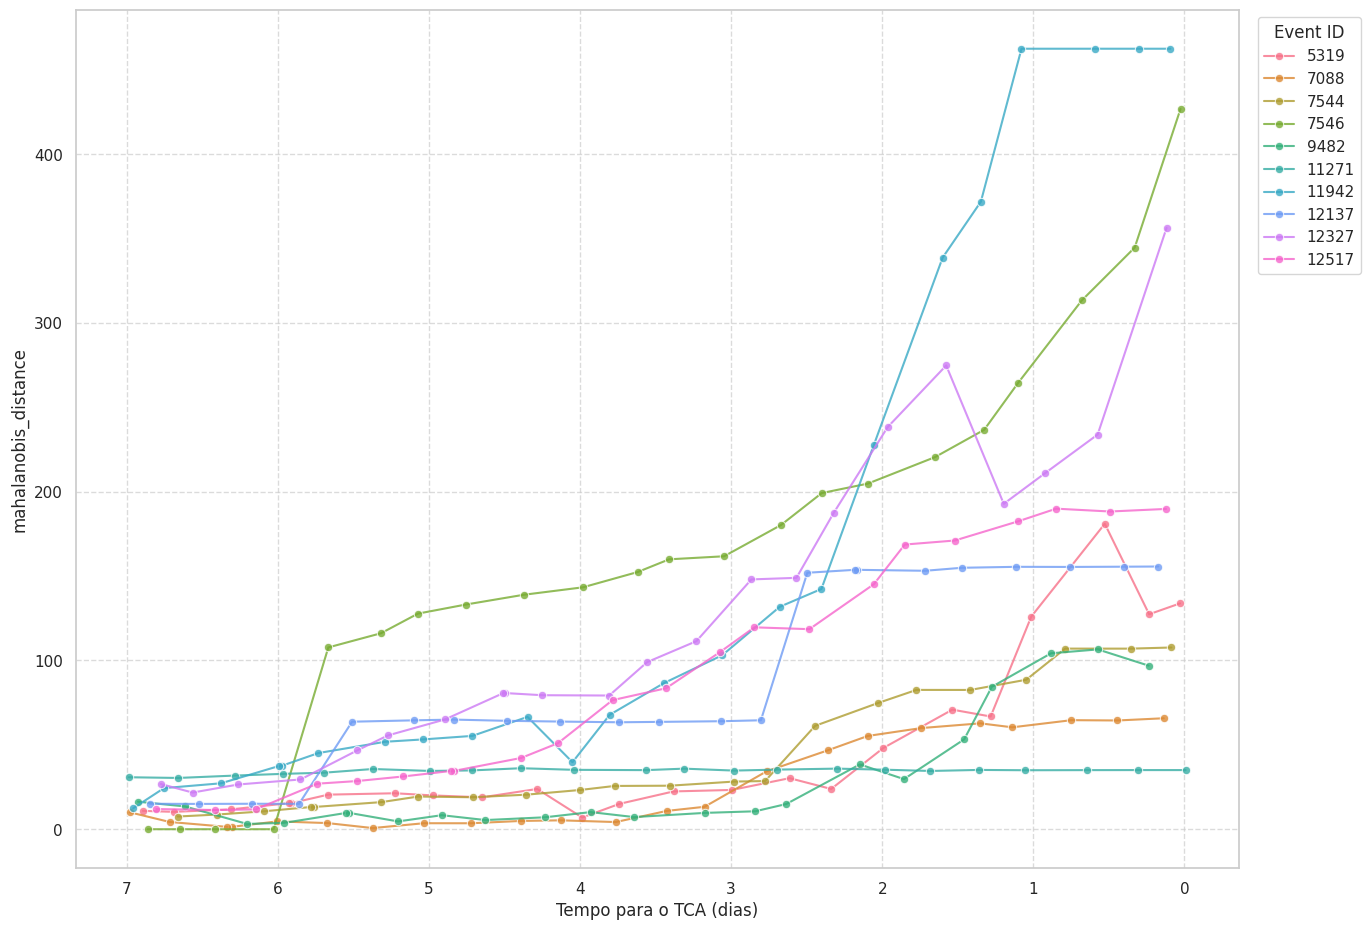

In [81]:
path = os.path.join(fig_path, 'timeseries')
os.makedirs(path, exist_ok=True)

columns_to_plot = df_plot.drop(columns=['event_id', 'time_to_tca']).columns
n_events_to_plot = get_config(eda_configs, 'n_events_to_plot')
for y_var in columns_to_plot:
    plot_timeseries(df_plot, y_var, n_events_to_plot, path)

# Save Parsed Dataset

Save the parsed dataset to a new csv file, that can be used in the next steps.

In [82]:
csv_path = "../dataset/processed_data.csv"
if os.path.exists(csv_path):
    os.remove(csv_path)

df.to_csv('../dataset/processed_data.csv', index=False)

output_path = csv_path.replace(".csv", ".zip")

with zipfile.ZipFile(output_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, output_path)

# Add tex files to project report

In [83]:
def include_tex_files(main_tex_path, target_section, directory):
    with open(main_tex_path, 'r') as f:
        content = f.read()
    
    section_pattern = rf'\\section\{{({re.escape(target_section)})\}}'
    match = re.search(section_pattern, content)   
    section_start = match.start()
    
    tex_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.endswith('.tex'):
                continue
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, os.path.dirname(main_tex_path))
            tex_files.append(rel_path)
                        
    tex_files.sort()
    input_commands = "\n".join([f"\\input{{{path}}}" for path in tex_files])
    insertion_point = content.find('\n', section_start) + 1
    new_content = content[:insertion_point] + "\n" + input_commands + "\n" + content[insertion_point:]
    
    with open(main_tex_path, 'w', encoding='utf-8') as f:
        f.write(new_content)

In [84]:
include_tex_files("../reports/test.tex", "TABLES", '../tables')
include_tex_files("../reports/test.tex", "FIGURES", '../figures')